# Best y for train

Models:

- MLP
- GMF

Variations:

- DeepGroup (avg)
- Expert Softmax
- DL Group AGG with mean
- IPA

In [ ]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2)

"""
results/ml1m/groups-2-mlp_gpa_avg.csv
results/ml1m/groups-2-mlp_gpa_expert.csv
results/ml1m/groups-2-mlp_gpa_mlp_mean.csv
results/ml1m/groups-2-mlp_gpa_softmax.csv
results/ml1m/groups-2-mlp_ipa.csv
"""
"""
@param model: mlp o gmf
"""
def get_models_files(model):
    return {
        'ipa': model+'_ipa',
        'mo_avg': model+'_gpa_avg',
        'mo_expert': model+'_gpa_expert',
        'mo_softmax': model+'_gpa_softmax',
        'mlp_mean': model+'_gpa_mlp_mean',
    }

"""
@param labels_models: labels_models list
@param ds: dataset name
"""
def get_error(models_files, ds):
    datapath=f'../data/grupos/{ds}/'
    restulspath=f'../results/{ds}/'

    models = models_files.keys()
    
    # Load data
    groups = {}

    fromngroups=2
    tongroups=10

    # Load groups data
    for g in range(fromngroups,tongroups+1):
        groups[g] = pd.read_csv(f"{datapath}groups-{g}-test.csv")
        groups[g]['g'] = g
    
    
    # Load model predictions
    for g in range(fromngroups,tongroups+1):
        for model in models:
            file_name = models_files[model]
            groups[g][model] = pd.read_csv(
                f"{restulspath}groups-{g}-{file_name}.csv",
                header=0,
                names=["data"]
            )['data']

    # Compute error
    for g in range(fromngroups,tongroups+1):    # Each group
        for m in models:                        # Each model
            for gi in range(1,g+1):             # Each rating in group
                groups[g][m+'-error-'+str(gi)] = abs(groups[g]['rating-'+str(gi)] - groups[g][m])
                groups[g][m+'-error2-'+str(gi)] = (groups[g]['rating-'+str(gi)] - groups[g][m])**2

    for g in range(fromngroups,tongroups+1):    # Each group
        for m in models:                        # Each model
            groups[g][m+'-ERROR'] = groups[g].filter(regex='^'+m+'-error-',axis=1).mean(axis=1, skipna=True)
            groups[g][m+'-ERROR2'] = groups[g].filter(regex='^'+m+'-error2-',axis=1).mean(axis=1, skipna=True)
    
    # Join dict of groups
    results = pd.concat(groups, join='inner', ignore_index=True)
    # Calculate means
    means = results.groupby('g').mean()

    return means, results, groups

In [ ]:

"""
@data: dataframe
@val: "ERROR" o "ERROR2"
@val_text: MAE o MSE
@model_name: Model name for title
@dataset_text: Dataset name for title: "ML1M", Anime", etc.
"""
def barplot(data, val, val_text, model_name, dataset_text):
    models = [m+'-'+val for m in get_models_files('').keys()]
    df = data[['g']+models]
    df.columns = ['g']+list(get_models_files('').keys())
    fig = df.groupby('g').mean().plot(
        kind='bar',
        yerr=df.groupby('g').std(),
        figsize=(30, 5)
    )
    fig.legend(bbox_to_anchor=(1.0, 1.0))
    fig.set(title=f'({model_name}) {dataset_text}')
    fig.set_xlabel('Group Size')
    fig.set_ylabel(val_text)
    fig.plot()

"""
@data: dataframe
@val: "ERROR" o "ERROR2"
@val_text: MAE o MSE
@model_name: Model name for title
@dataset_text: Dataset name for title: "ML1M", Anime", etc.
"""
def lineplot(data, val, val_text, model_name, dataset_text):
    models = [m+'-'+val for m in get_models_files('').keys()]
    long_data = pd.melt(data[['g']+models], id_vars =['g'], value_vars=models)
    ax = sns.relplot(
        data=long_data.groupby(['g','variable']).mean(), kind="line",
        x="g", y="value", hue="variable",
        height=15, aspect=1.5
    )
    ax.set(title=f'({model_name}) {dataset_text}')
    ax.axes[0,0].set_xlabel('Group Size')
    ax.axes[0,0].set_ylabel(val_text)
    plt.show()


"""
@data: dataframe
@val: "ERROR" o "ERROR2"
@val_text: MAE o MSE
@model_name: Model name for title
@dataset_text: Dataset name for title: "ML1M", Anime", etc.
"""
def boxplot(data, val, val_text, model_name, dataset_text):
    models = [m+'-'+val for m in get_models_files('').keys()]
    df = data[['g']+models]
    df.columns = ['g']+list(get_models_files('').keys())
    fig = df.groupby('g').plot(
        kind='box',
        by=['g'],
        figsize=(30, 5)
    )
    fig.legend(bbox_to_anchor=(1.0, 1.0))
    fig.set(title=f'({model_name}) {dataset_text}')
    fig.set_xlabel('Group Size')
    fig.set_ylabel(val_text)
    fig.plot()

In [3]:
#DS='ml1m'
#DS='ft'
#DS='anime'
#DS='netflix'




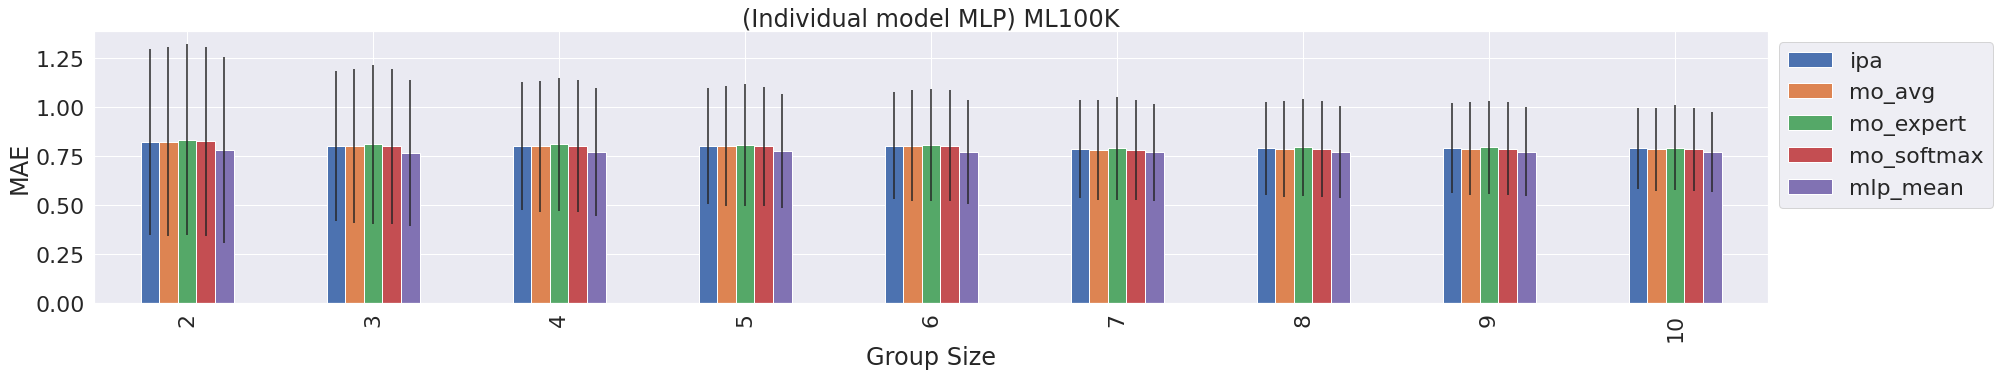

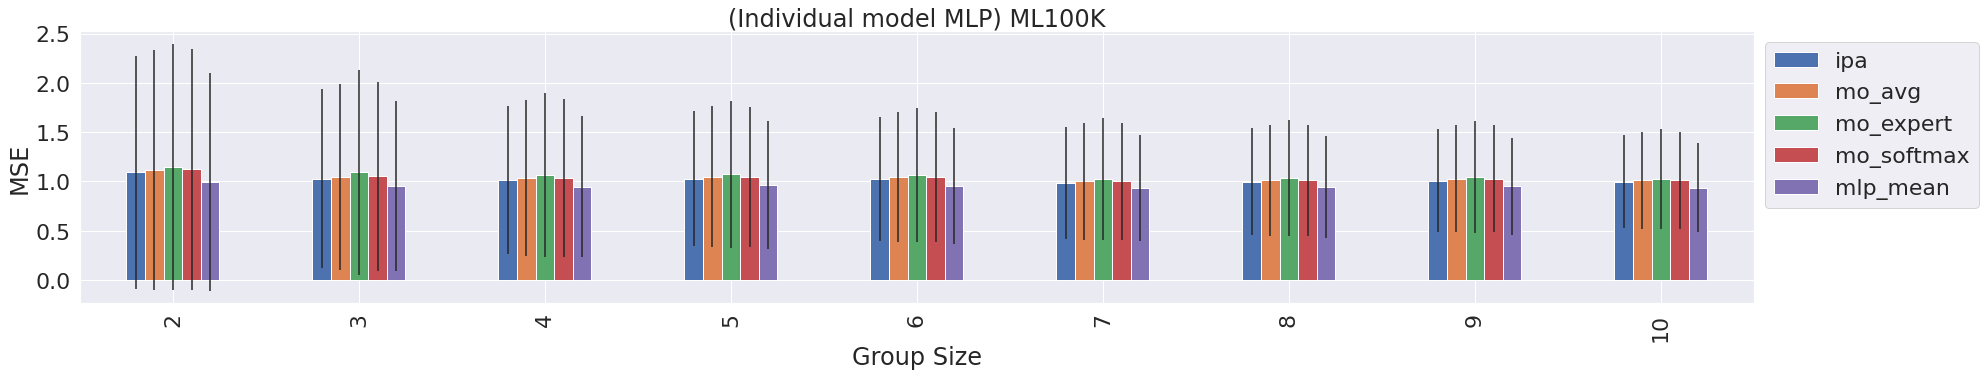

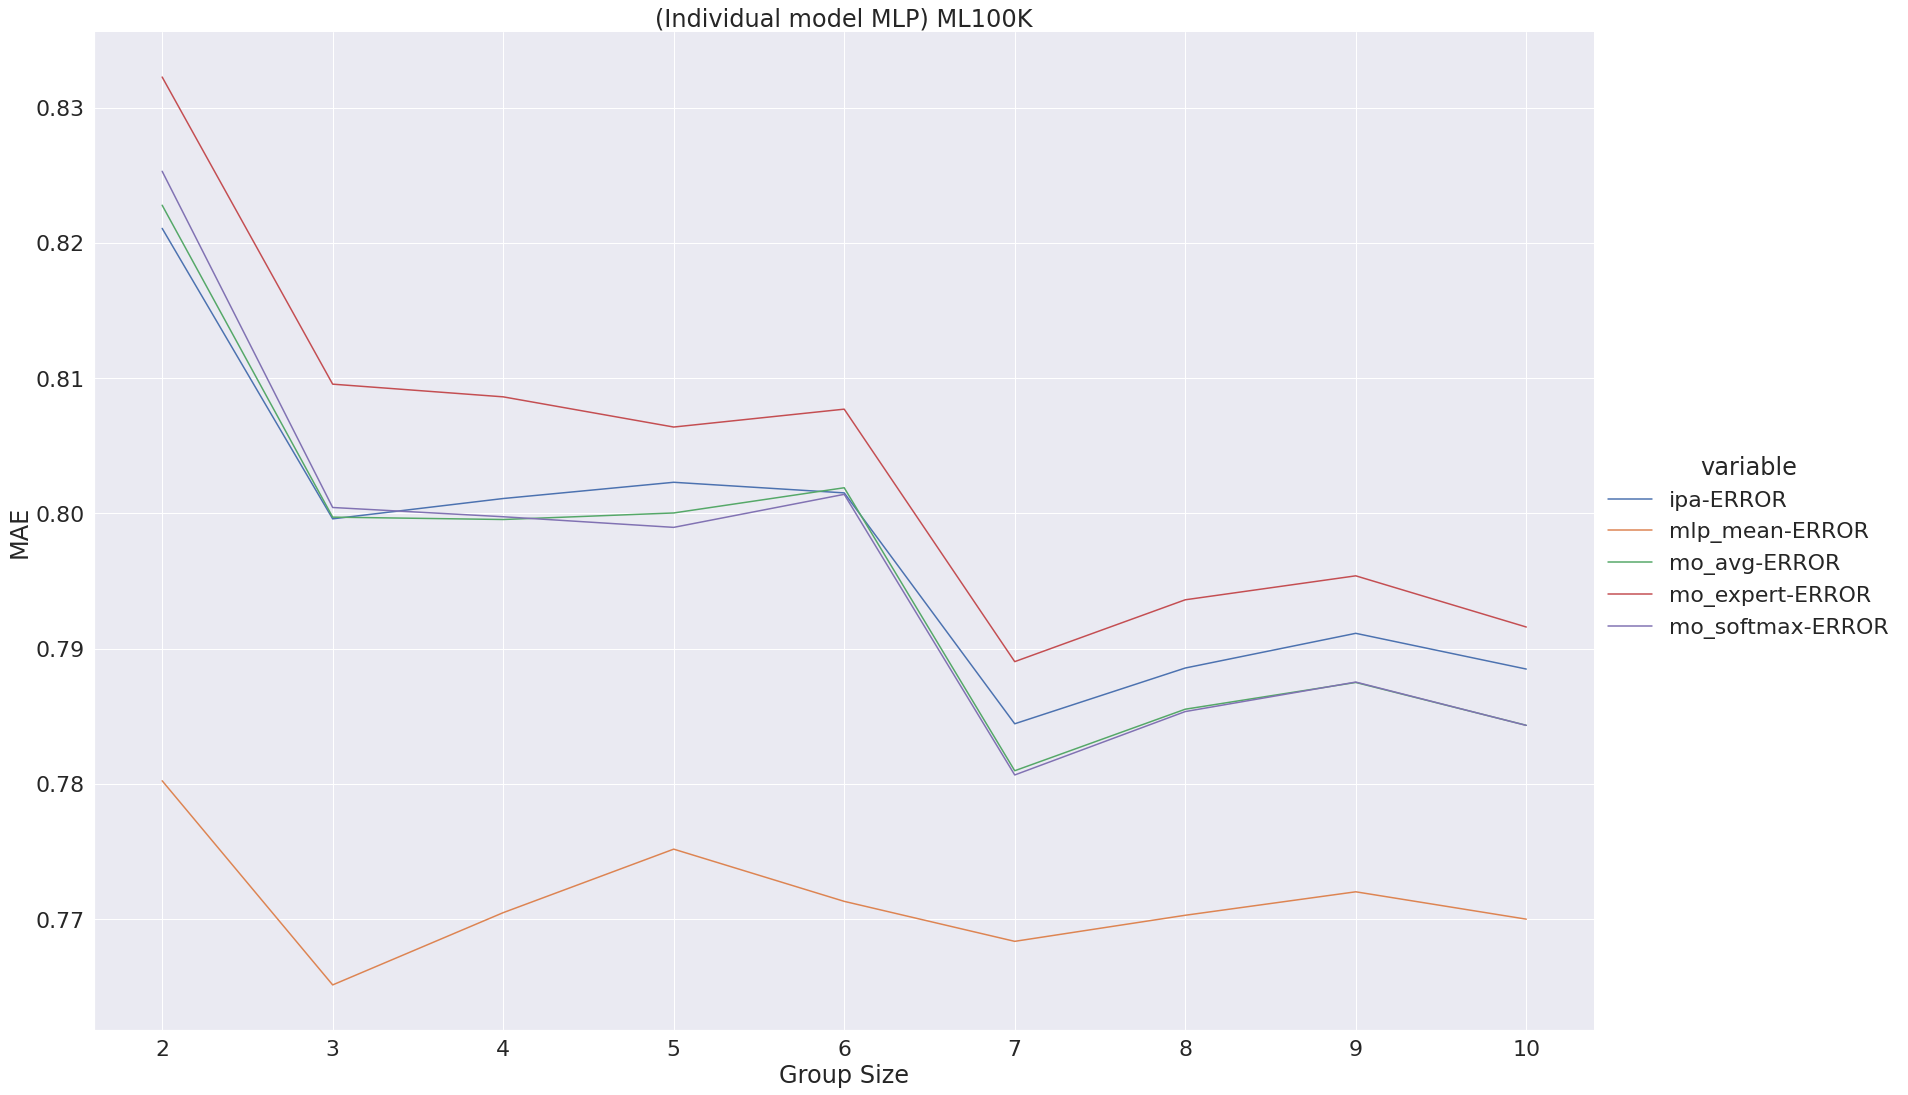

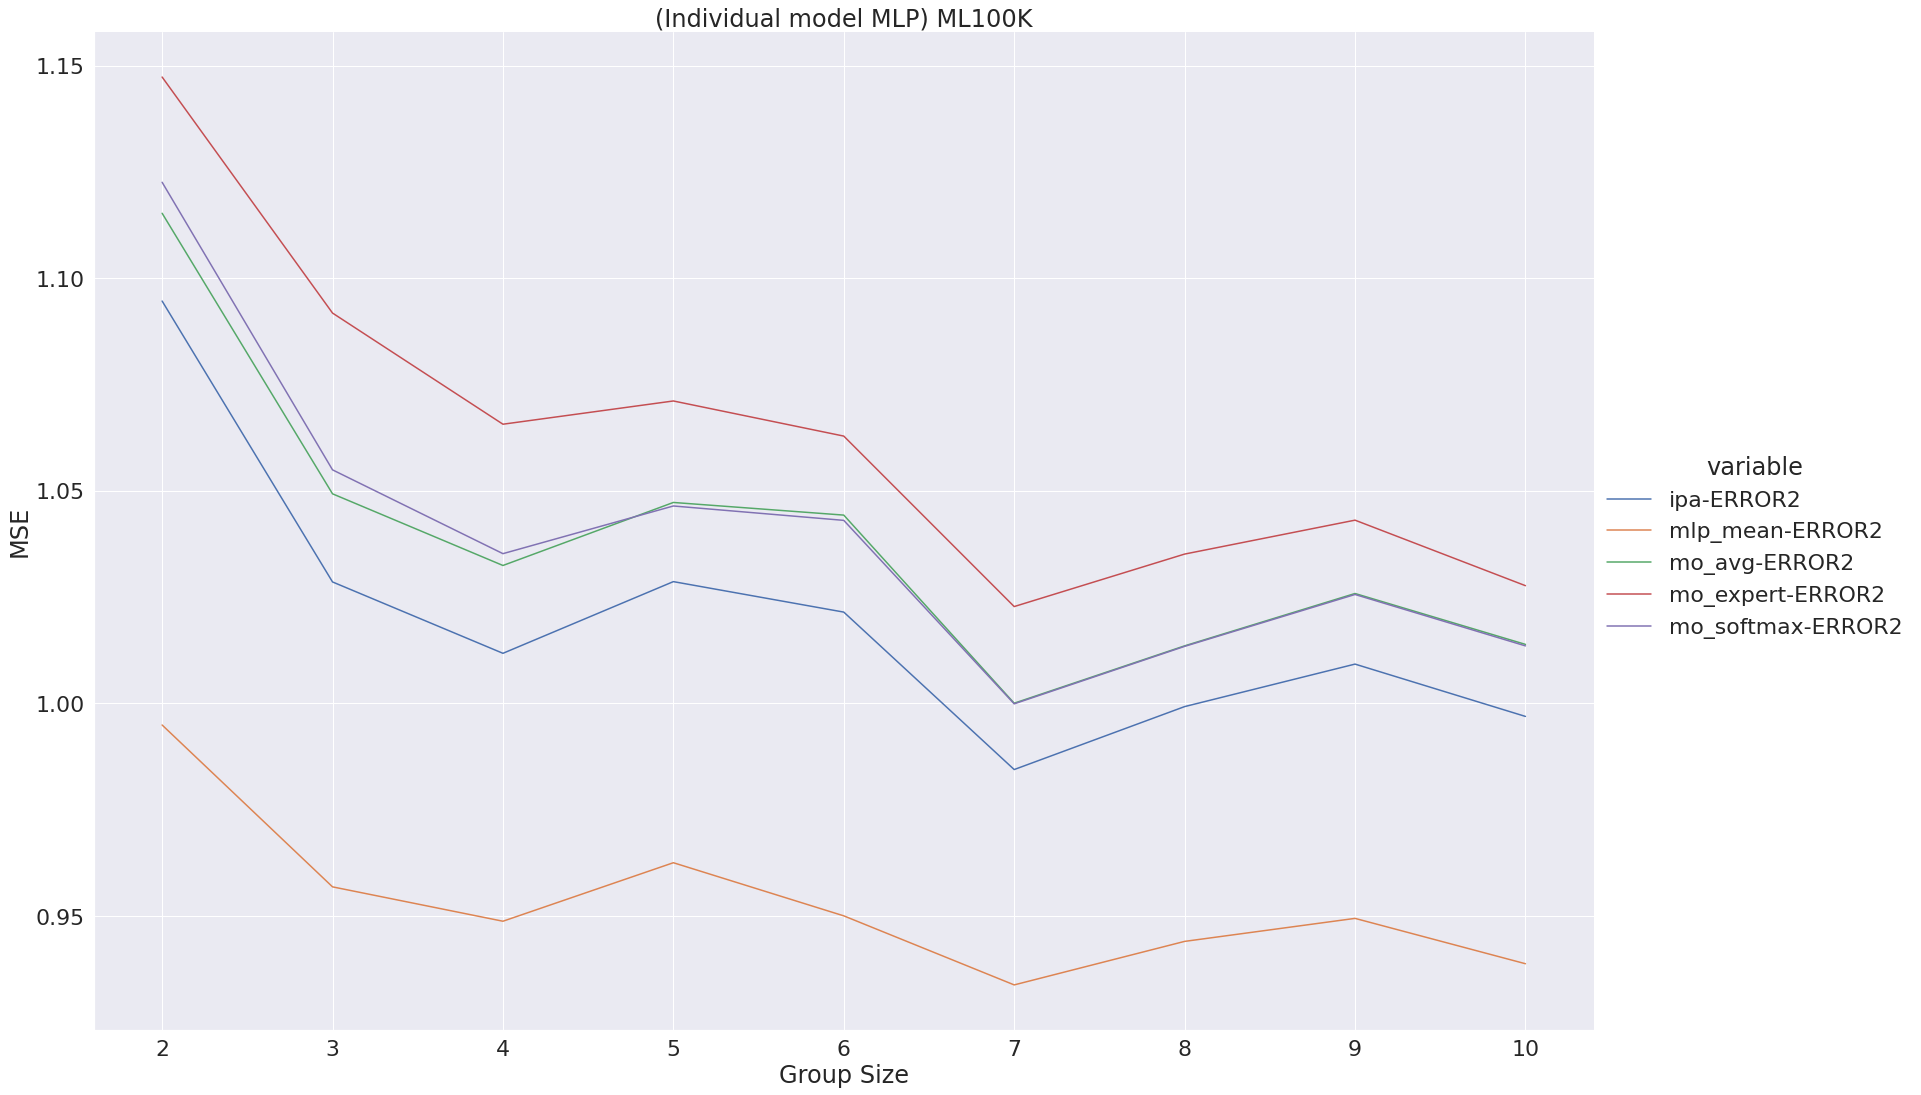

In [4]:
means, results, results_dict = get_error(get_models_files('mlp'), 'ml100k')
barplot(results, "ERROR", "MAE", "Individual model MLP", "ML100K")
barplot(results, "ERROR2", "MSE", "Individual model MLP", "ML100K")
lineplot(results, "ERROR", "MAE", "Individual model MLP", "ML100K")
lineplot(results, "ERROR2", "MSE", "Individual model MLP", "ML100K")

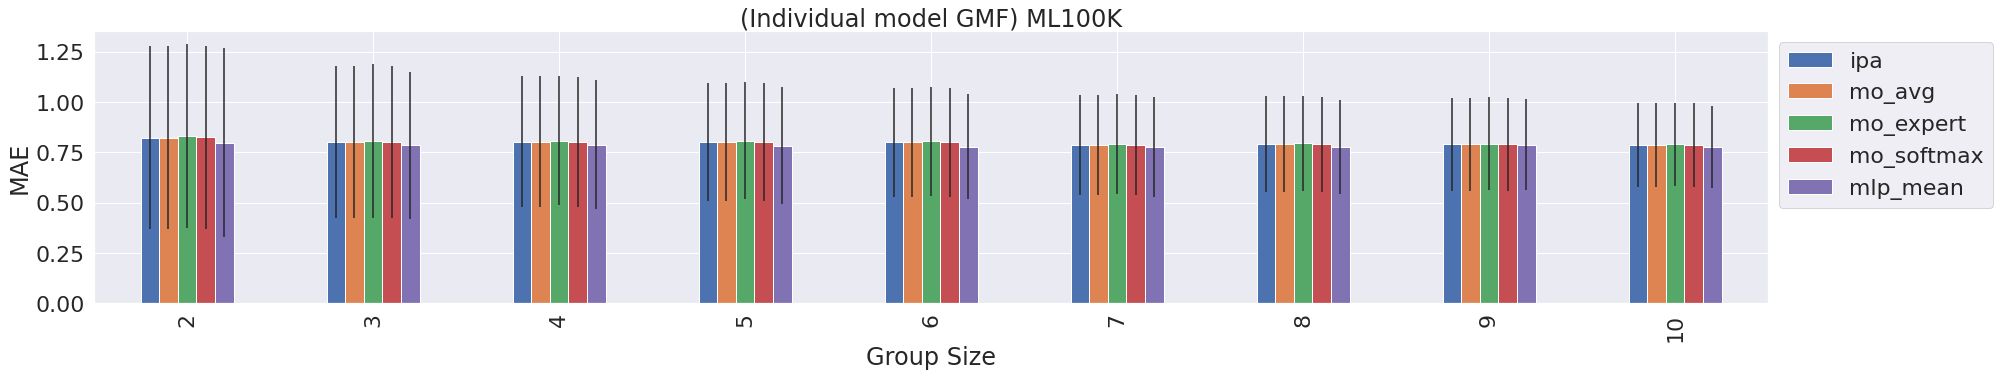

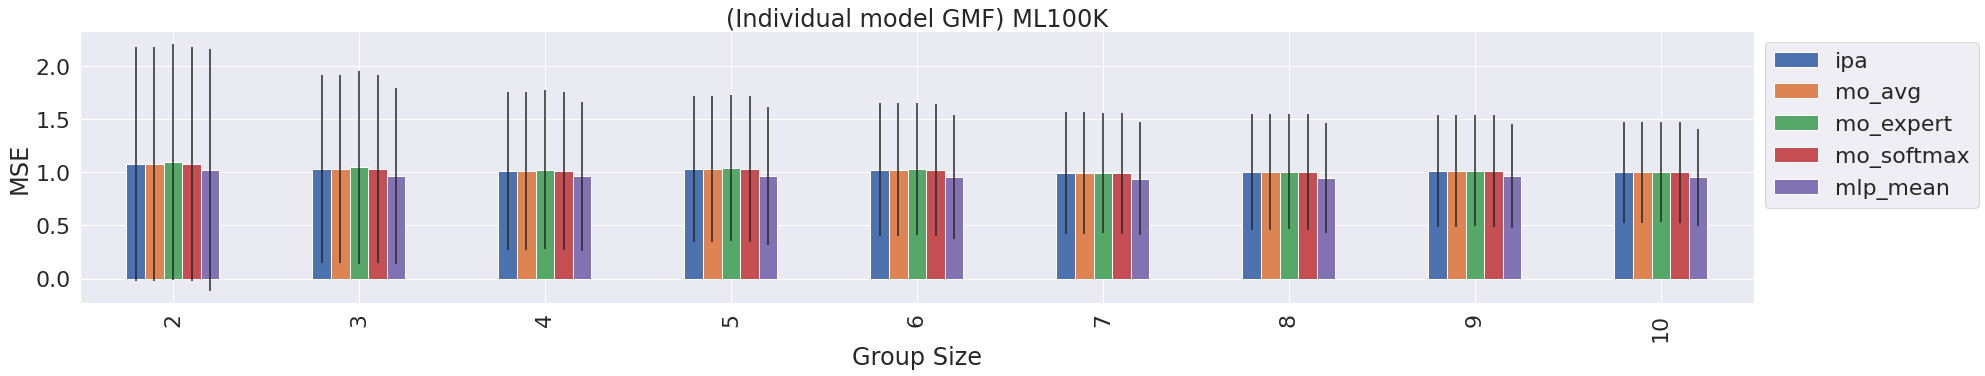

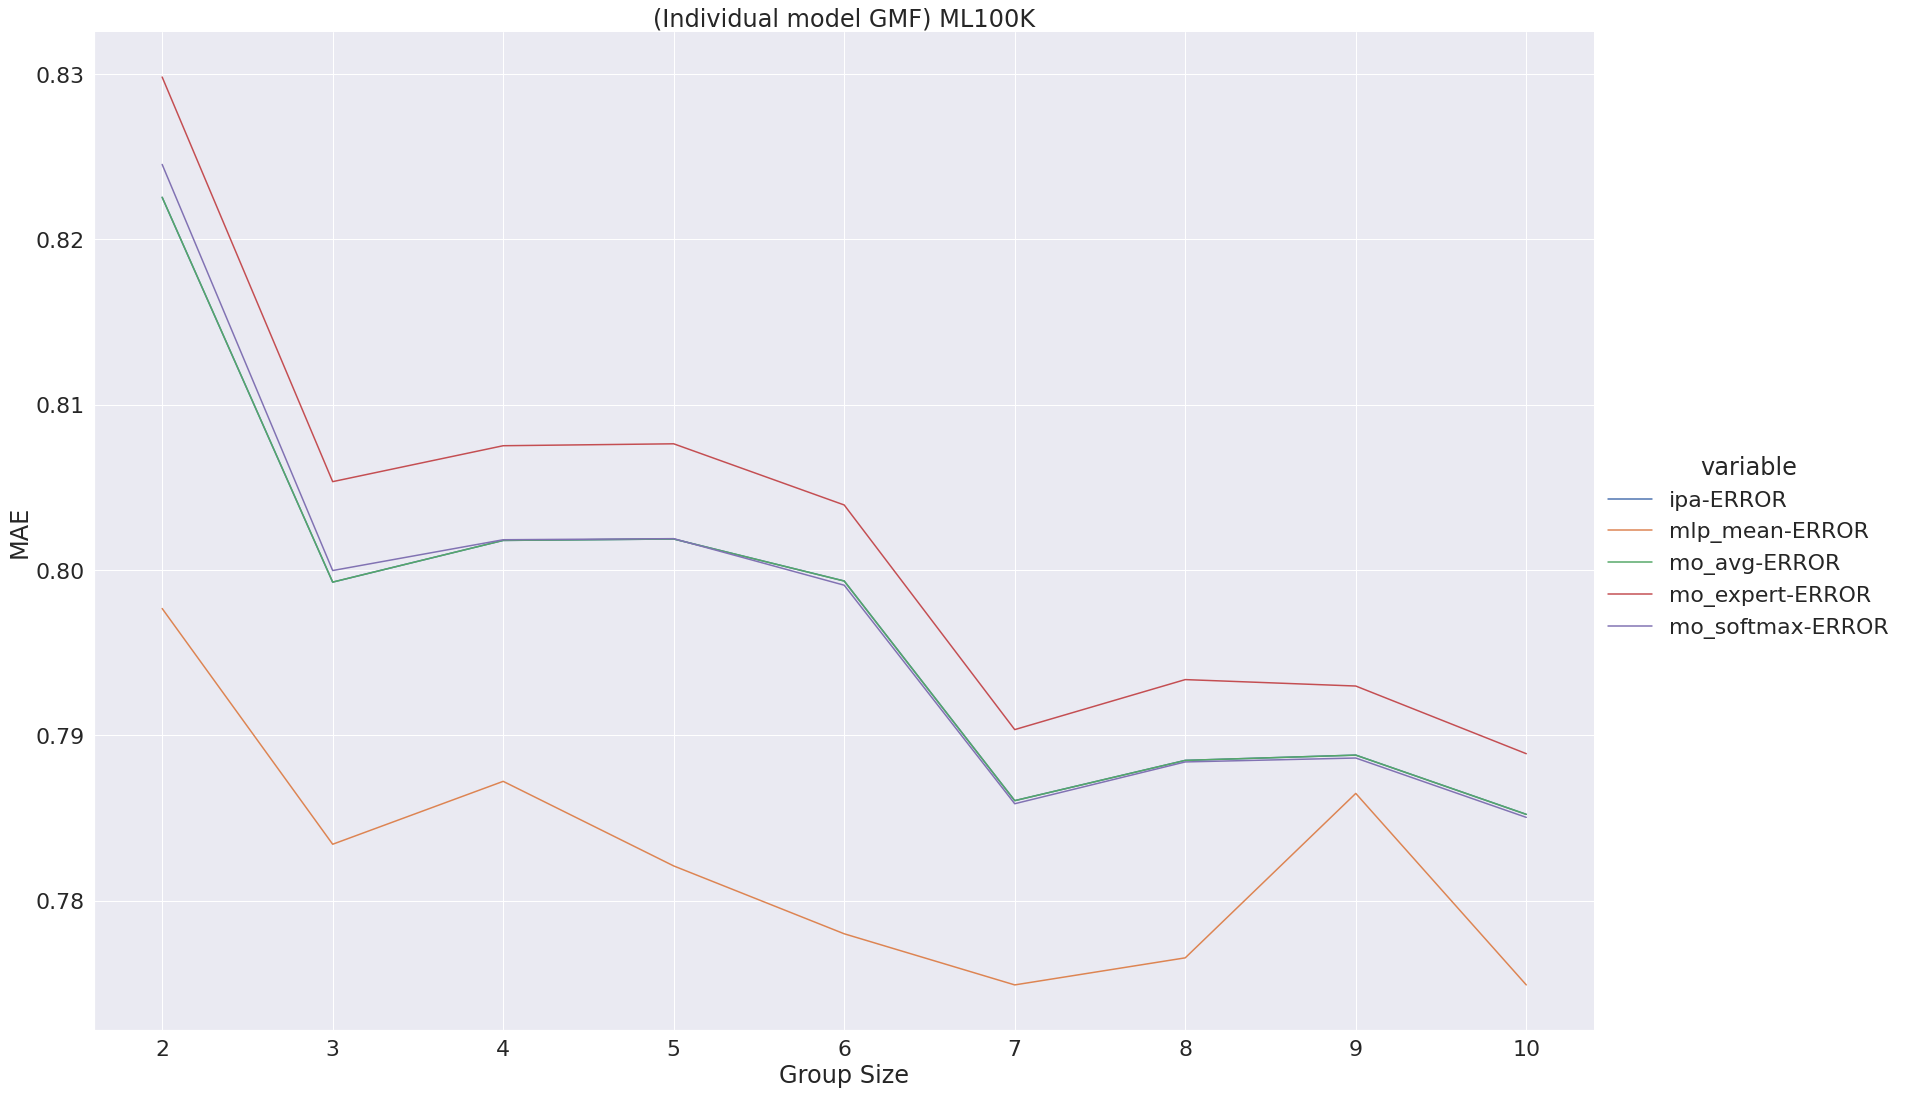

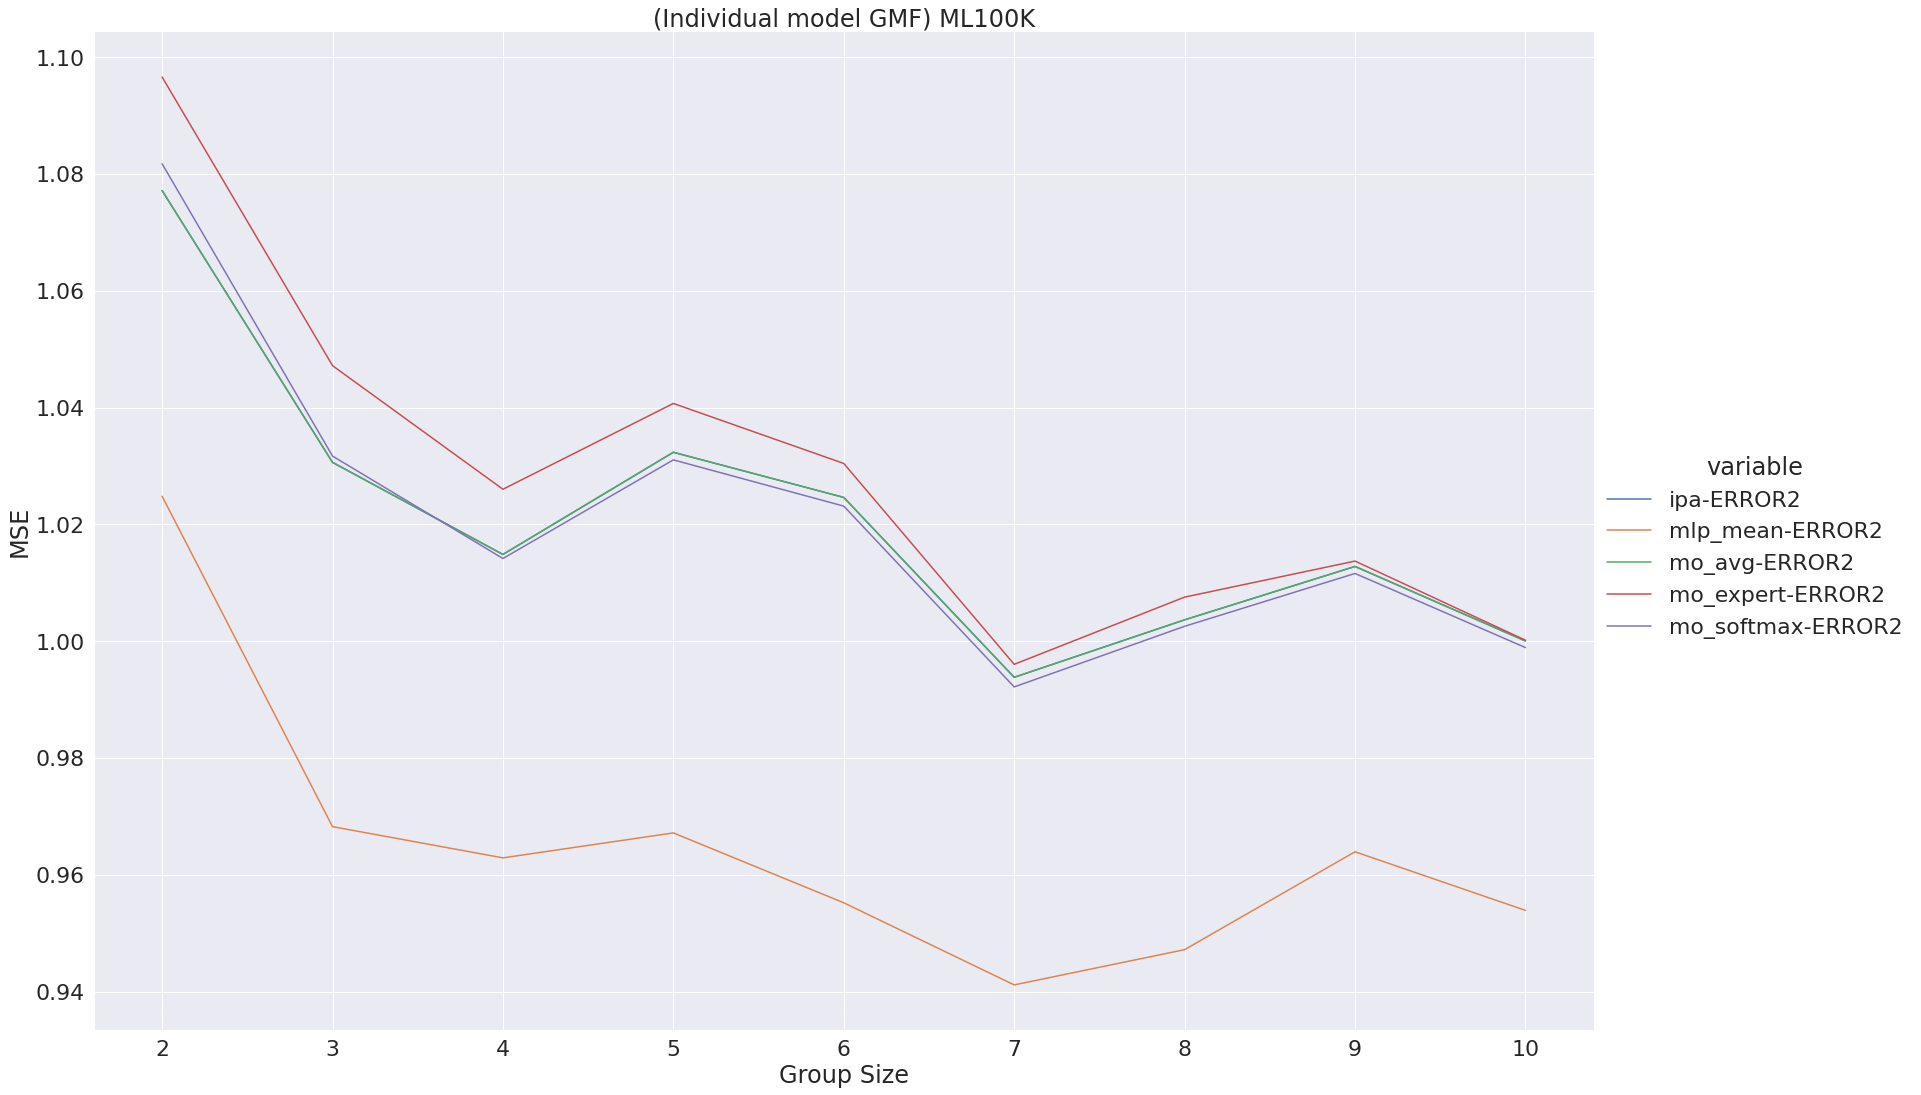

In [5]:
means, results, results_dict = get_error(get_models_files('gmf'), 'ml100k')
barplot(results, "ERROR", "MAE", "Individual model GMF", "ML100K")
barplot(results, "ERROR2", "MSE", "Individual model GMF", "ML100K")
lineplot(results, "ERROR", "MAE", "Individual model GMF", "ML100K")
lineplot(results, "ERROR2", "MSE", "Individual model GMF", "ML100K")

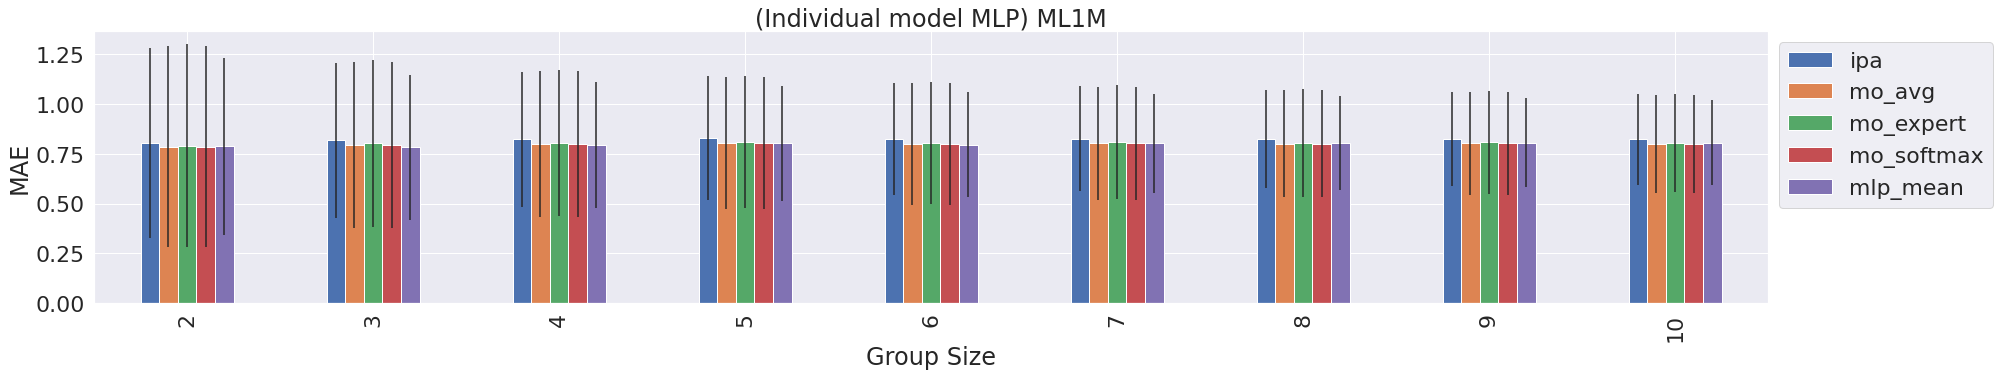

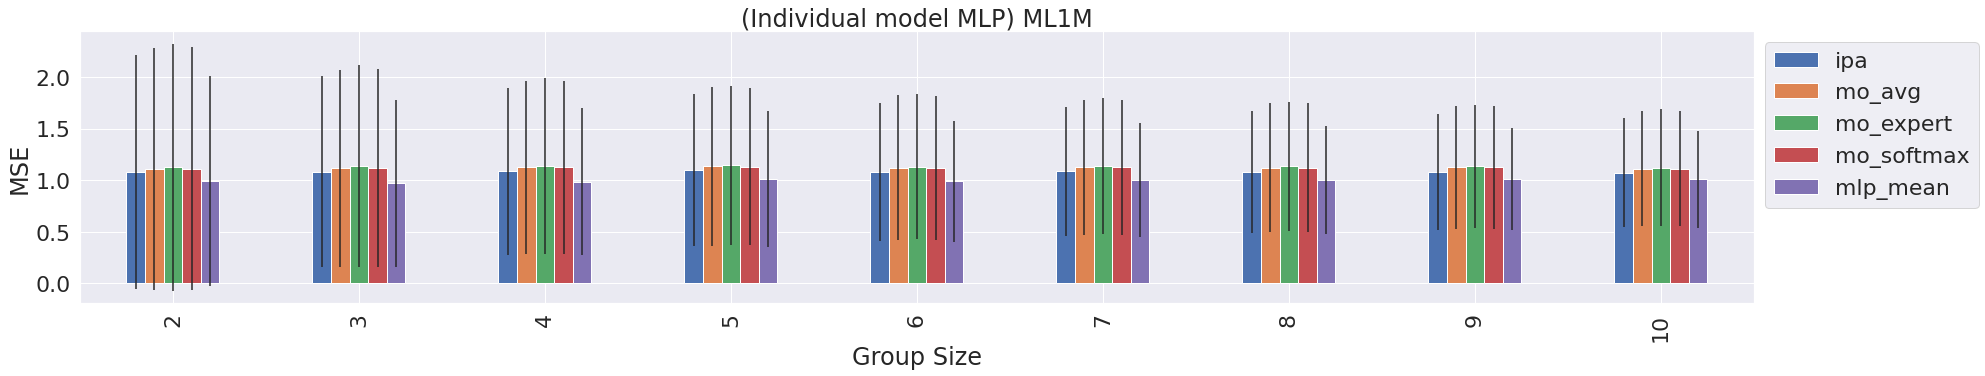

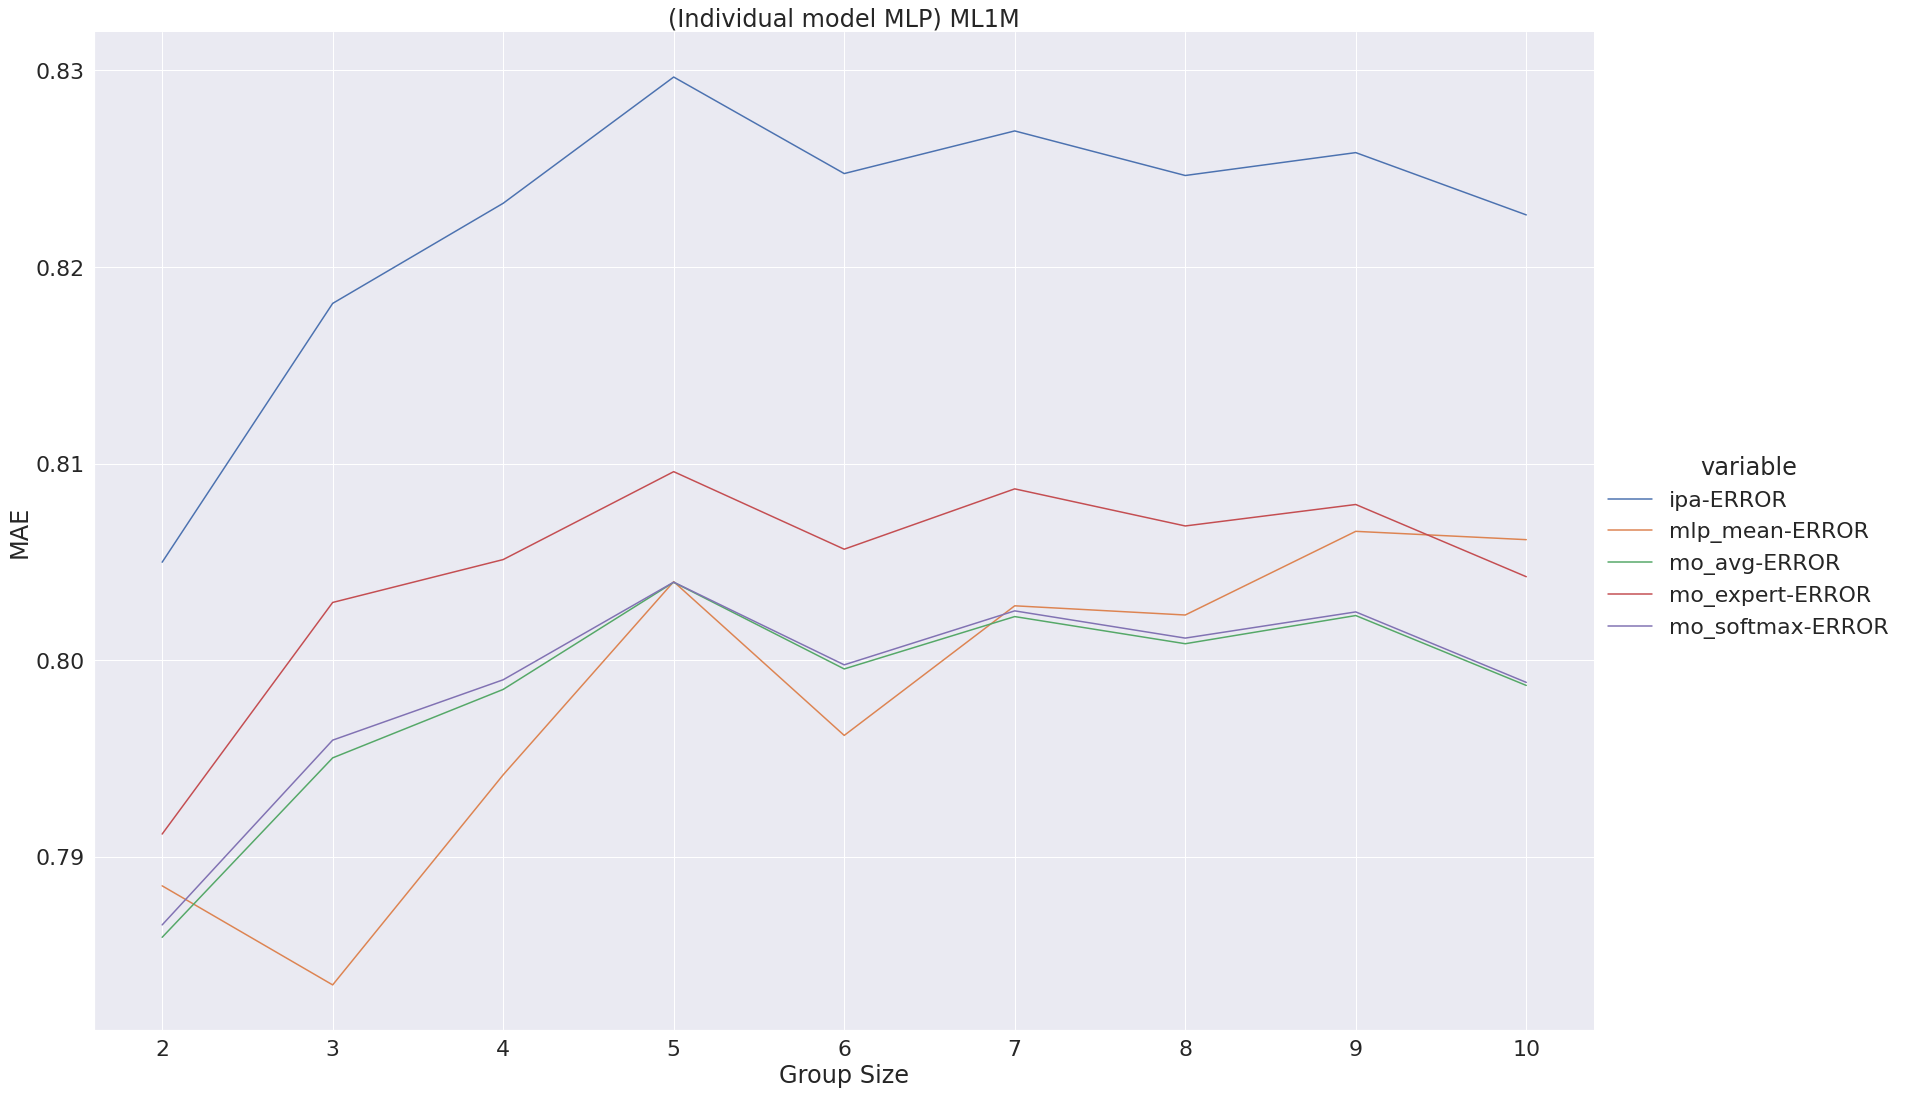

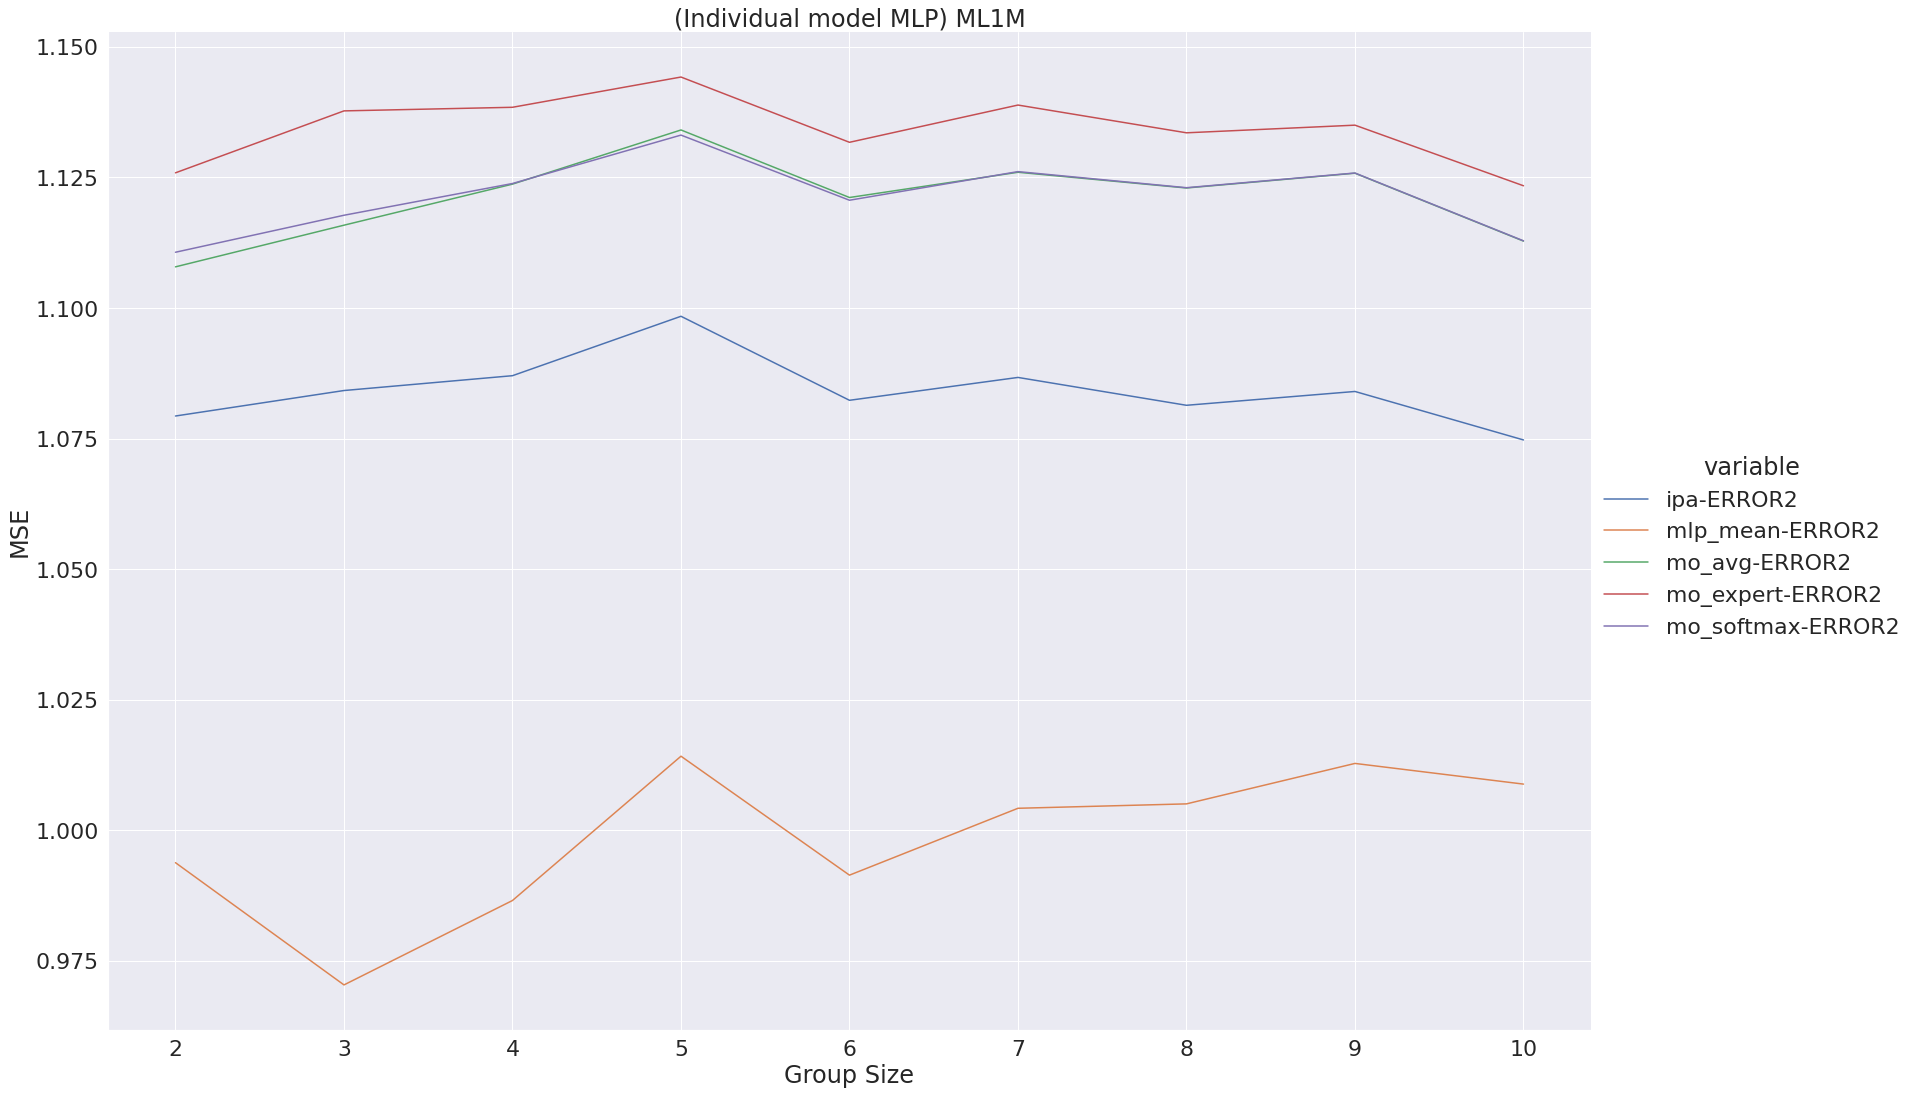

In [6]:
means, results, results_dict = get_error(get_models_files('mlp'), 'ml1m')
barplot(results, "ERROR", "MAE", "Individual model MLP", "ML1M")
barplot(results, "ERROR2", "MSE", "Individual model MLP", "ML1M")
lineplot(results, "ERROR", "MAE", "Individual model MLP", "ML1M")
lineplot(results, "ERROR2", "MSE", "Individual model MLP", "ML1M")

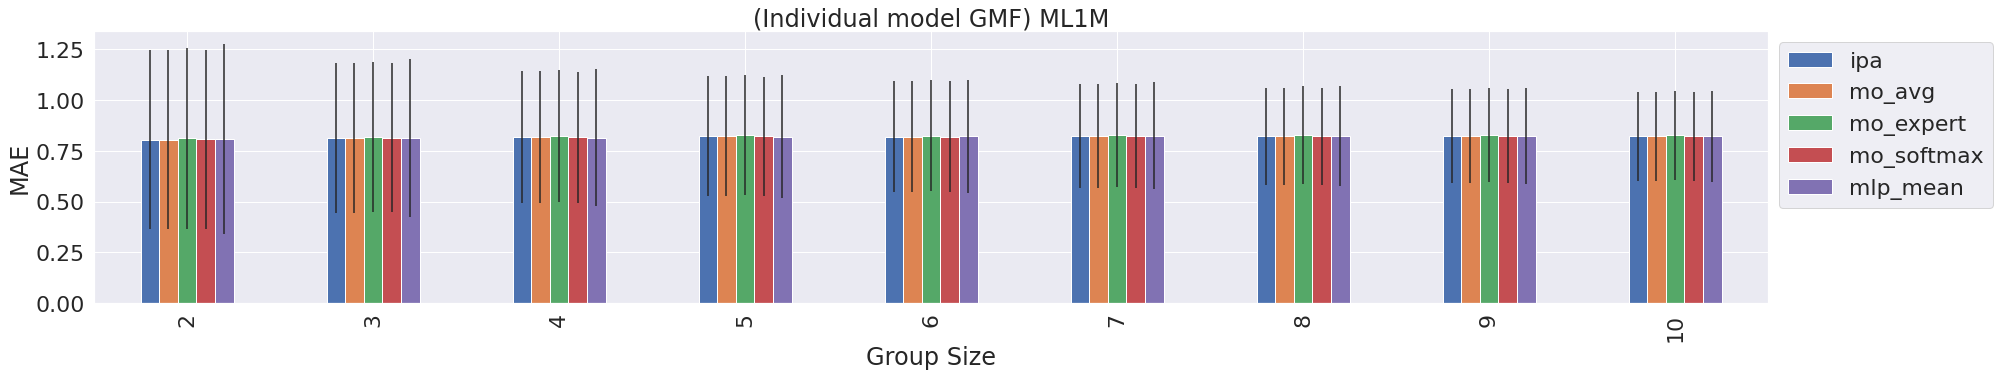

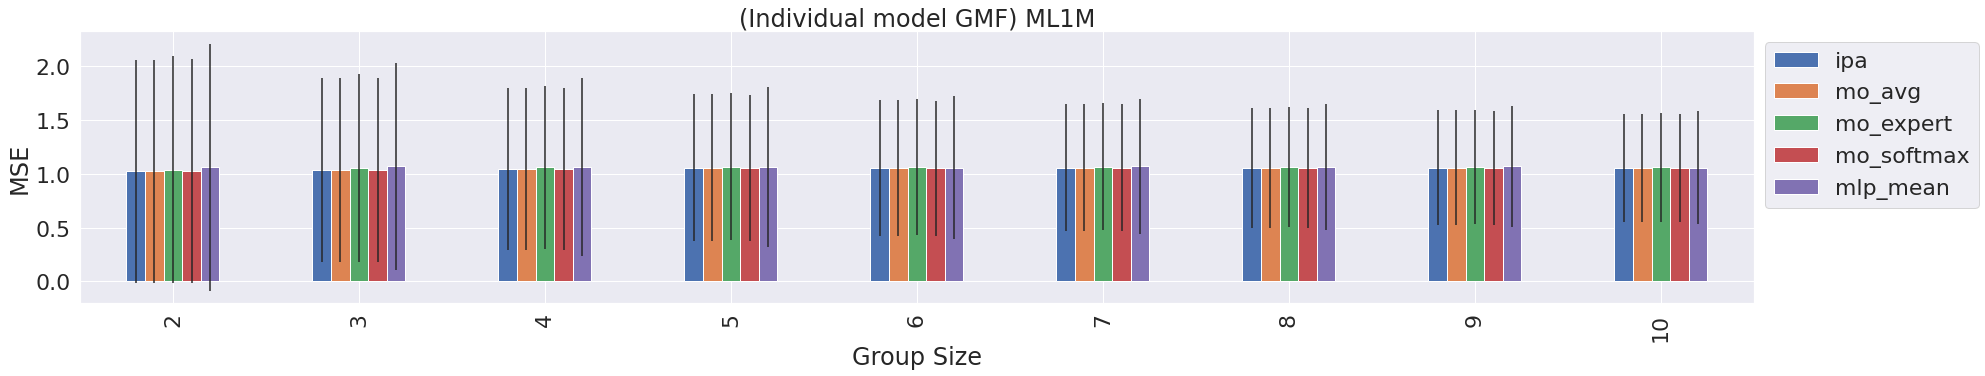

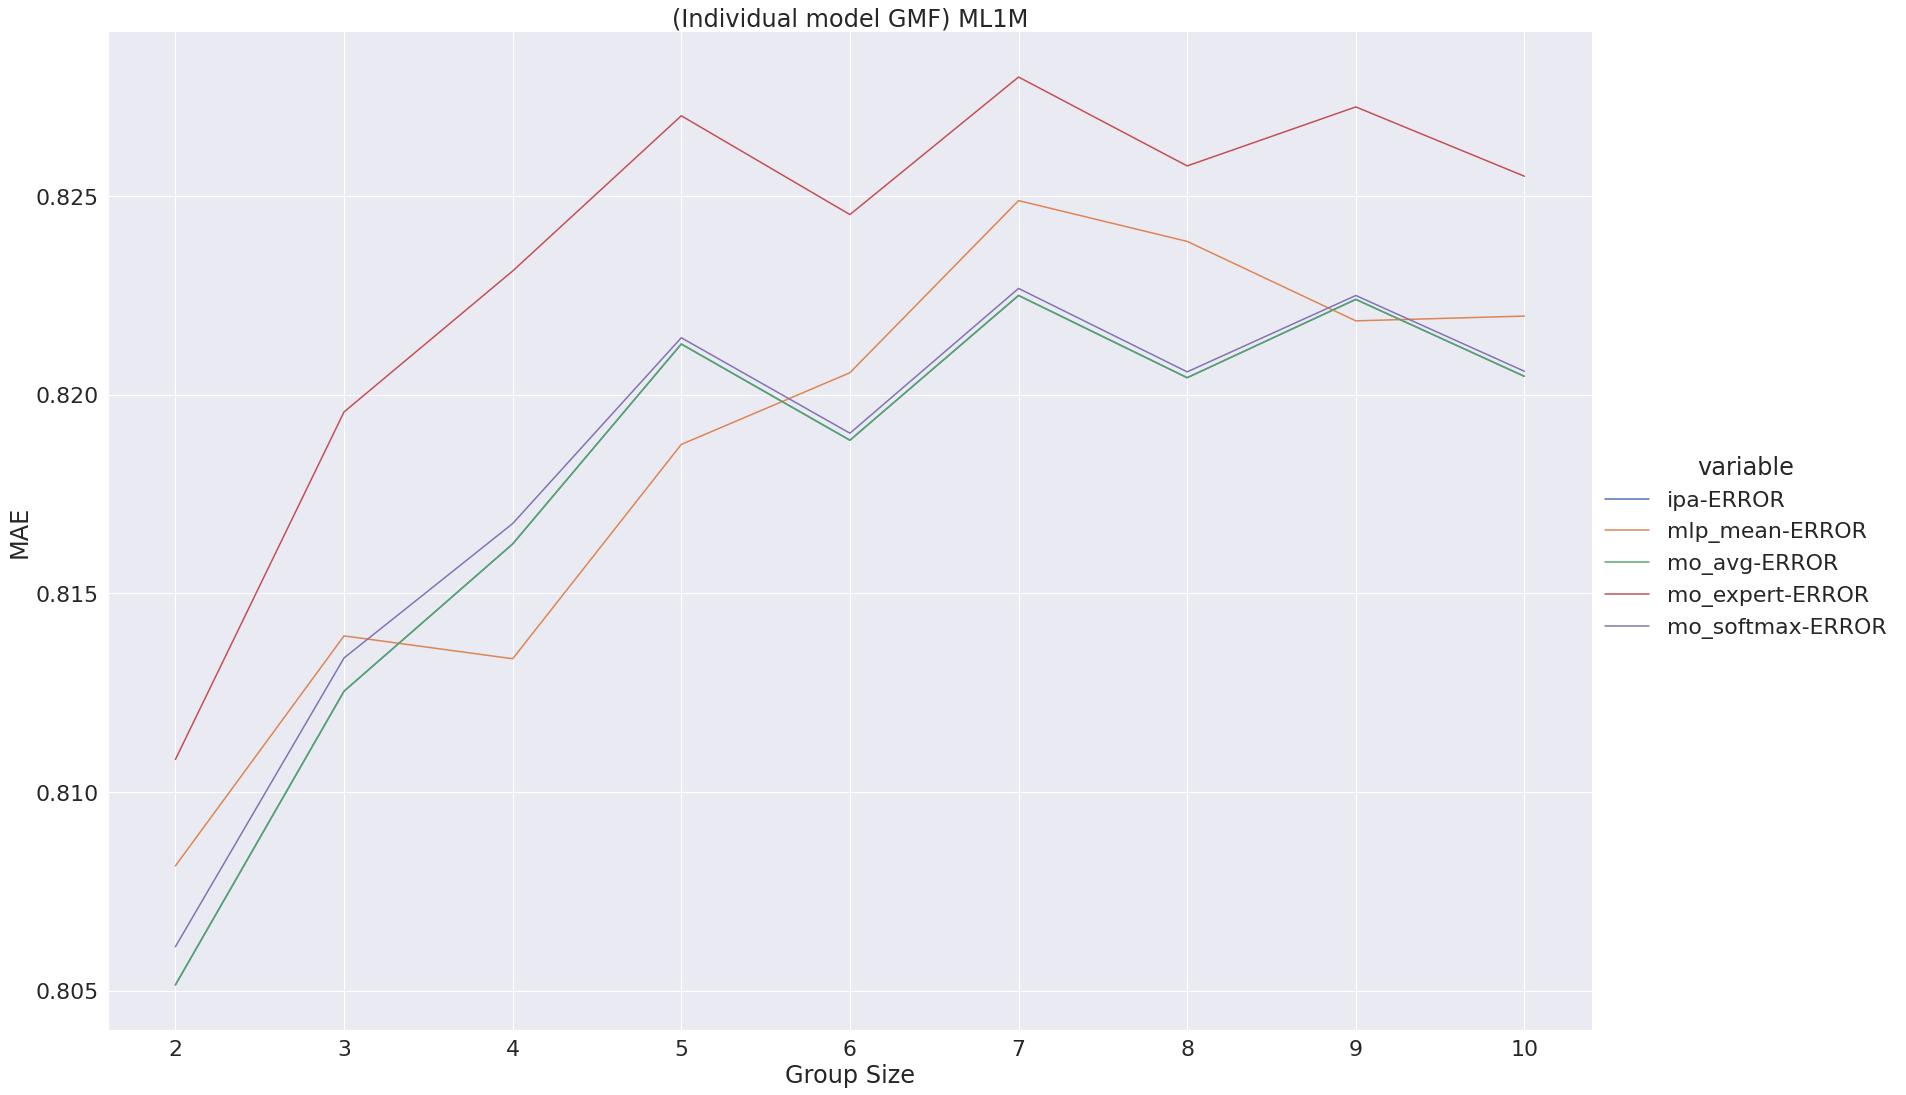

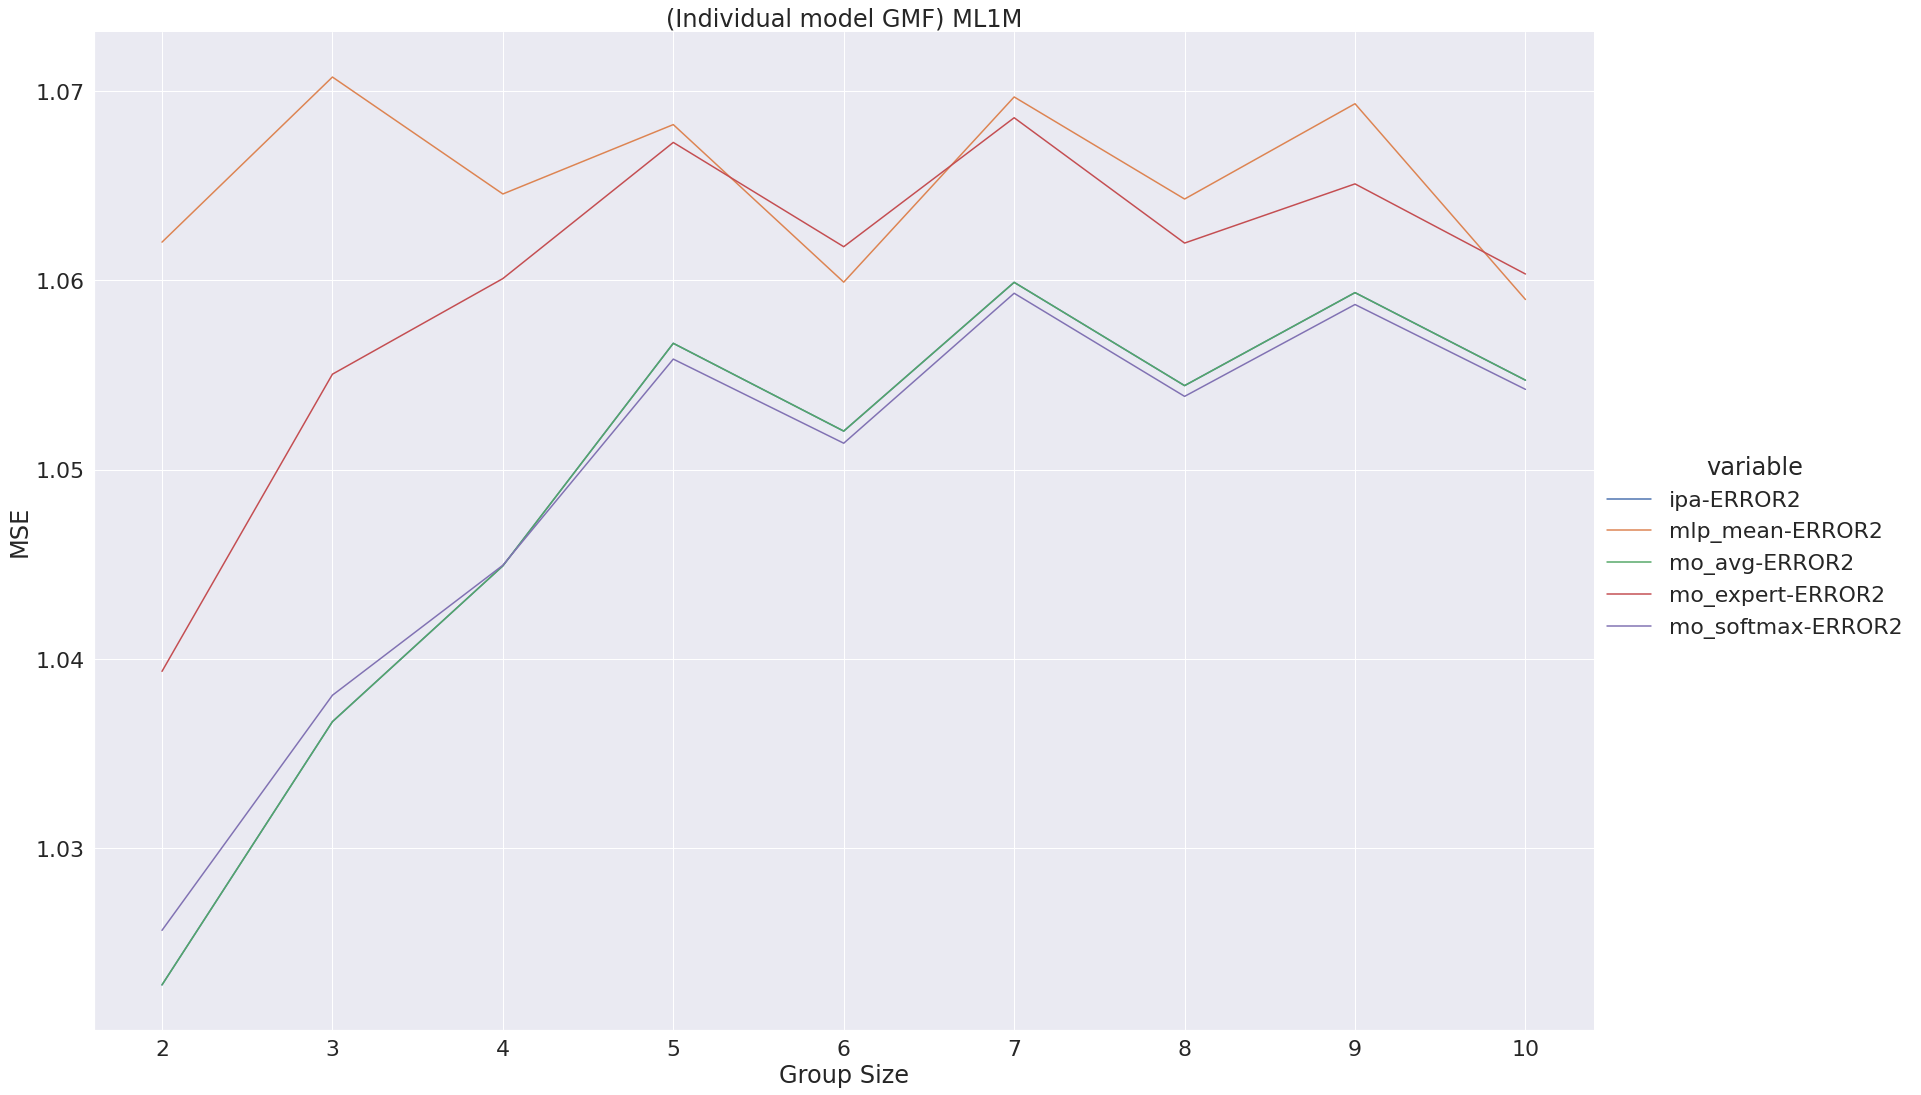

In [7]:
means, results, results_dict = get_error(get_models_files('gmf'), 'ml1m')
barplot(results, "ERROR", "MAE", "Individual model GMF", "ML1M")
barplot(results, "ERROR2", "MSE", "Individual model GMF", "ML1M")
lineplot(results, "ERROR", "MAE", "Individual model GMF", "ML1M")
lineplot(results, "ERROR2", "MSE", "Individual model GMF", "ML1M")

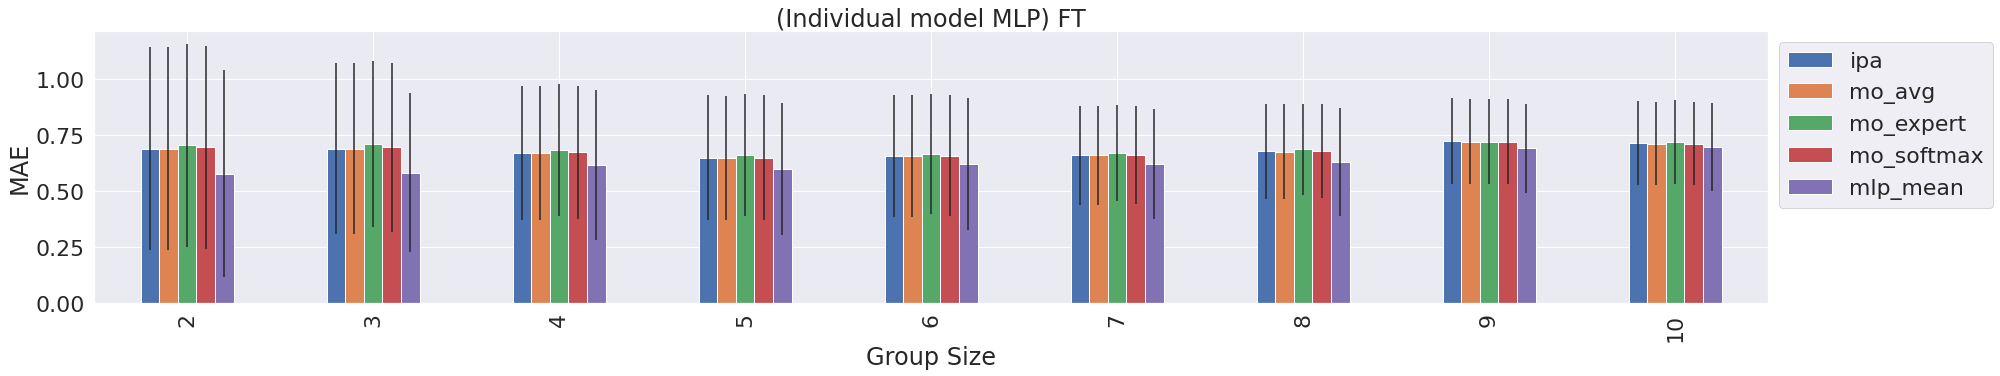

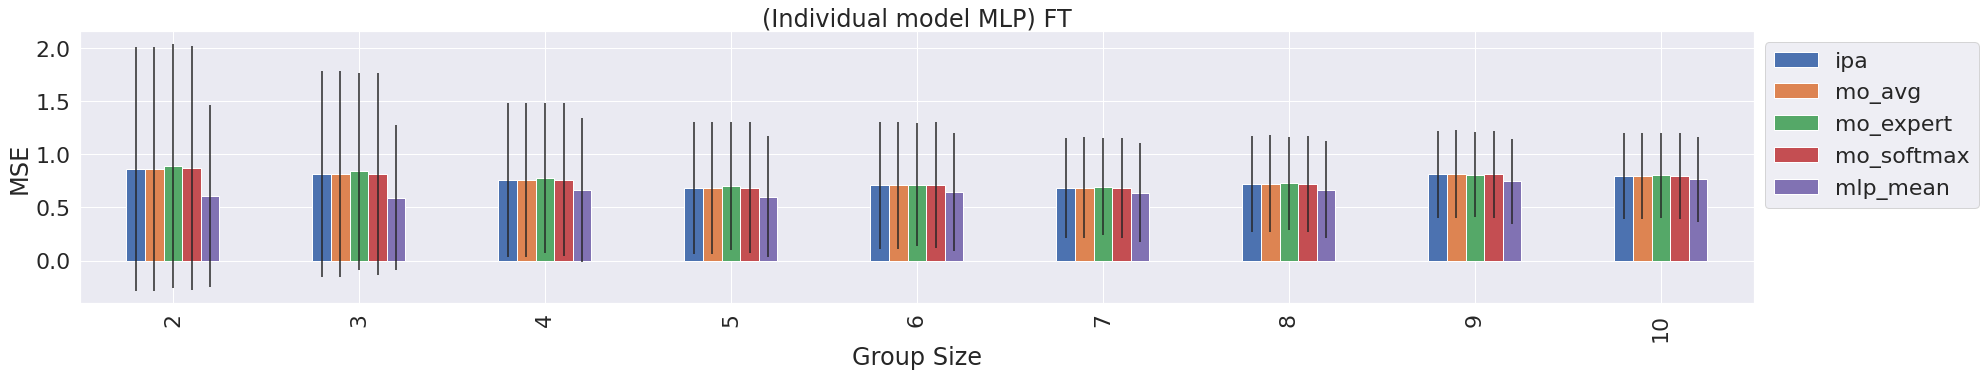

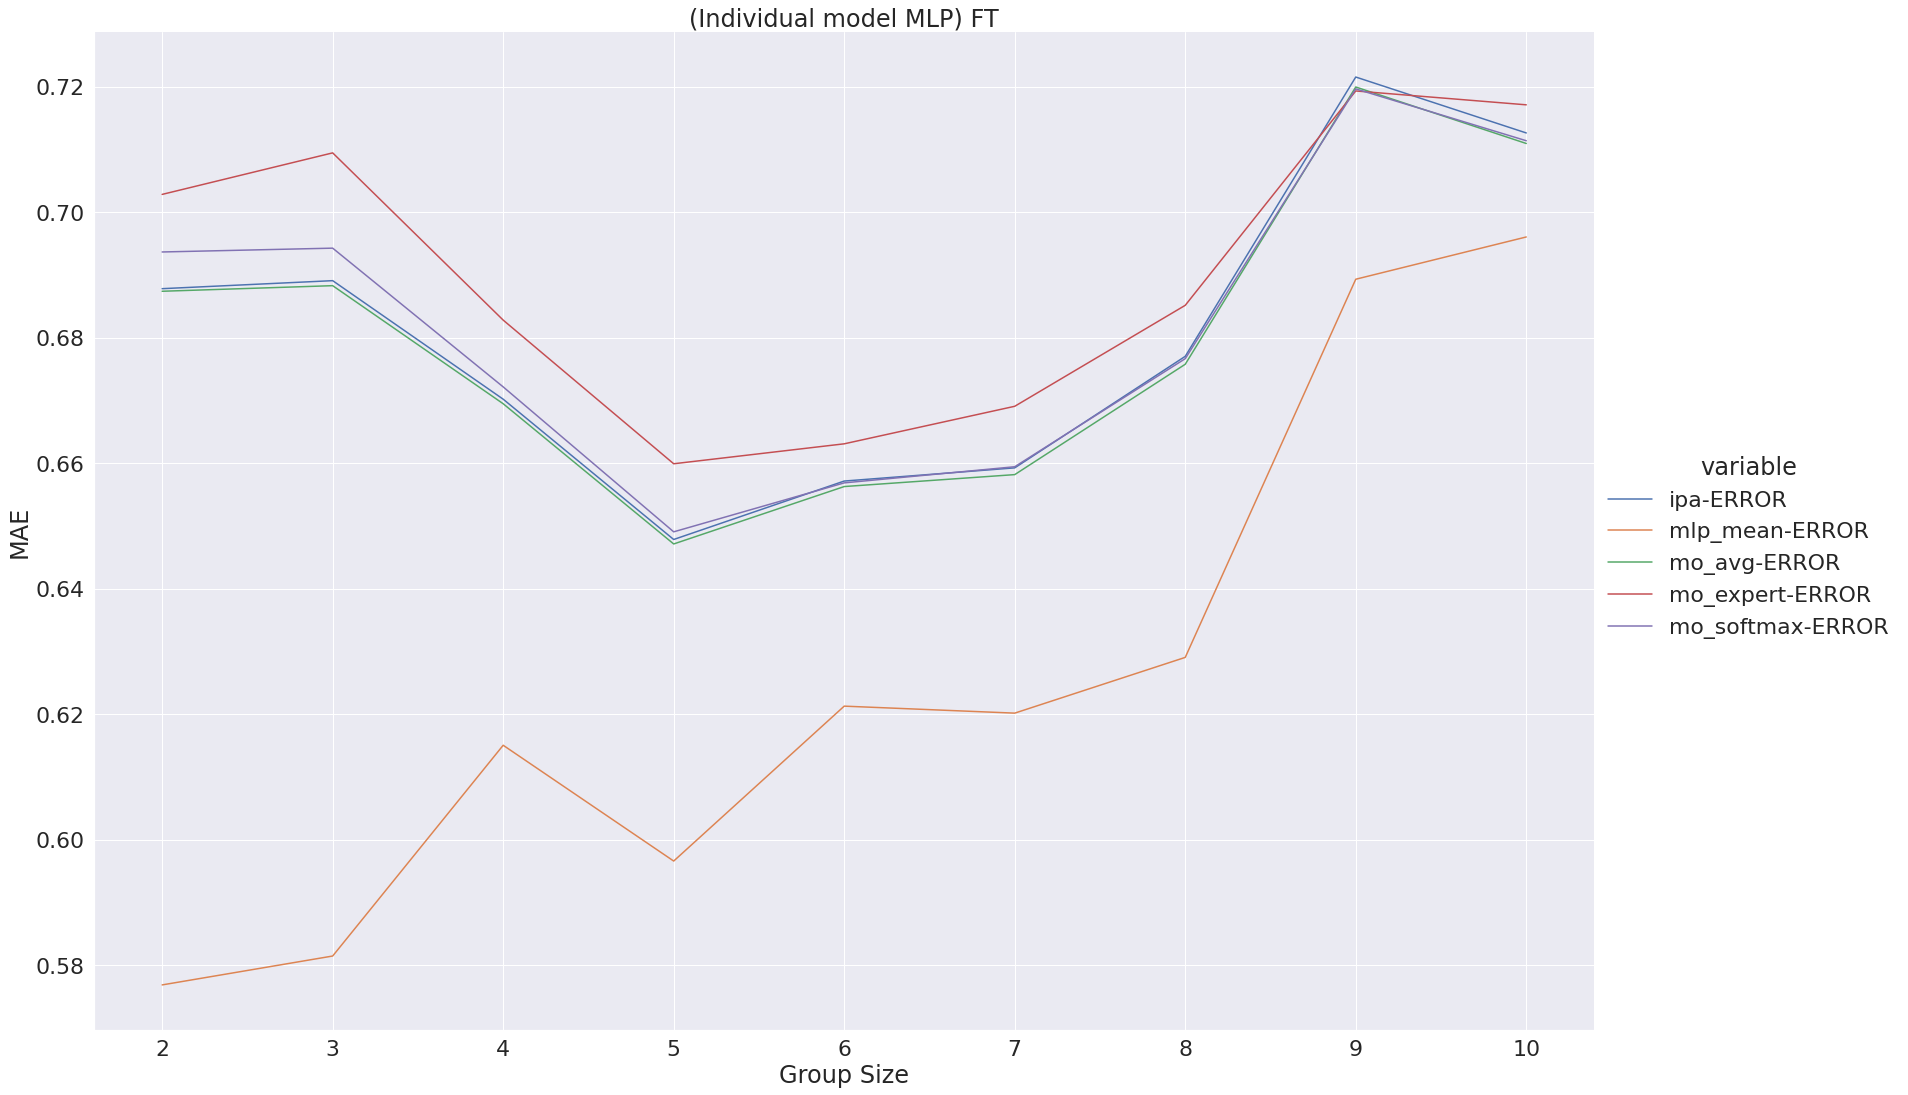

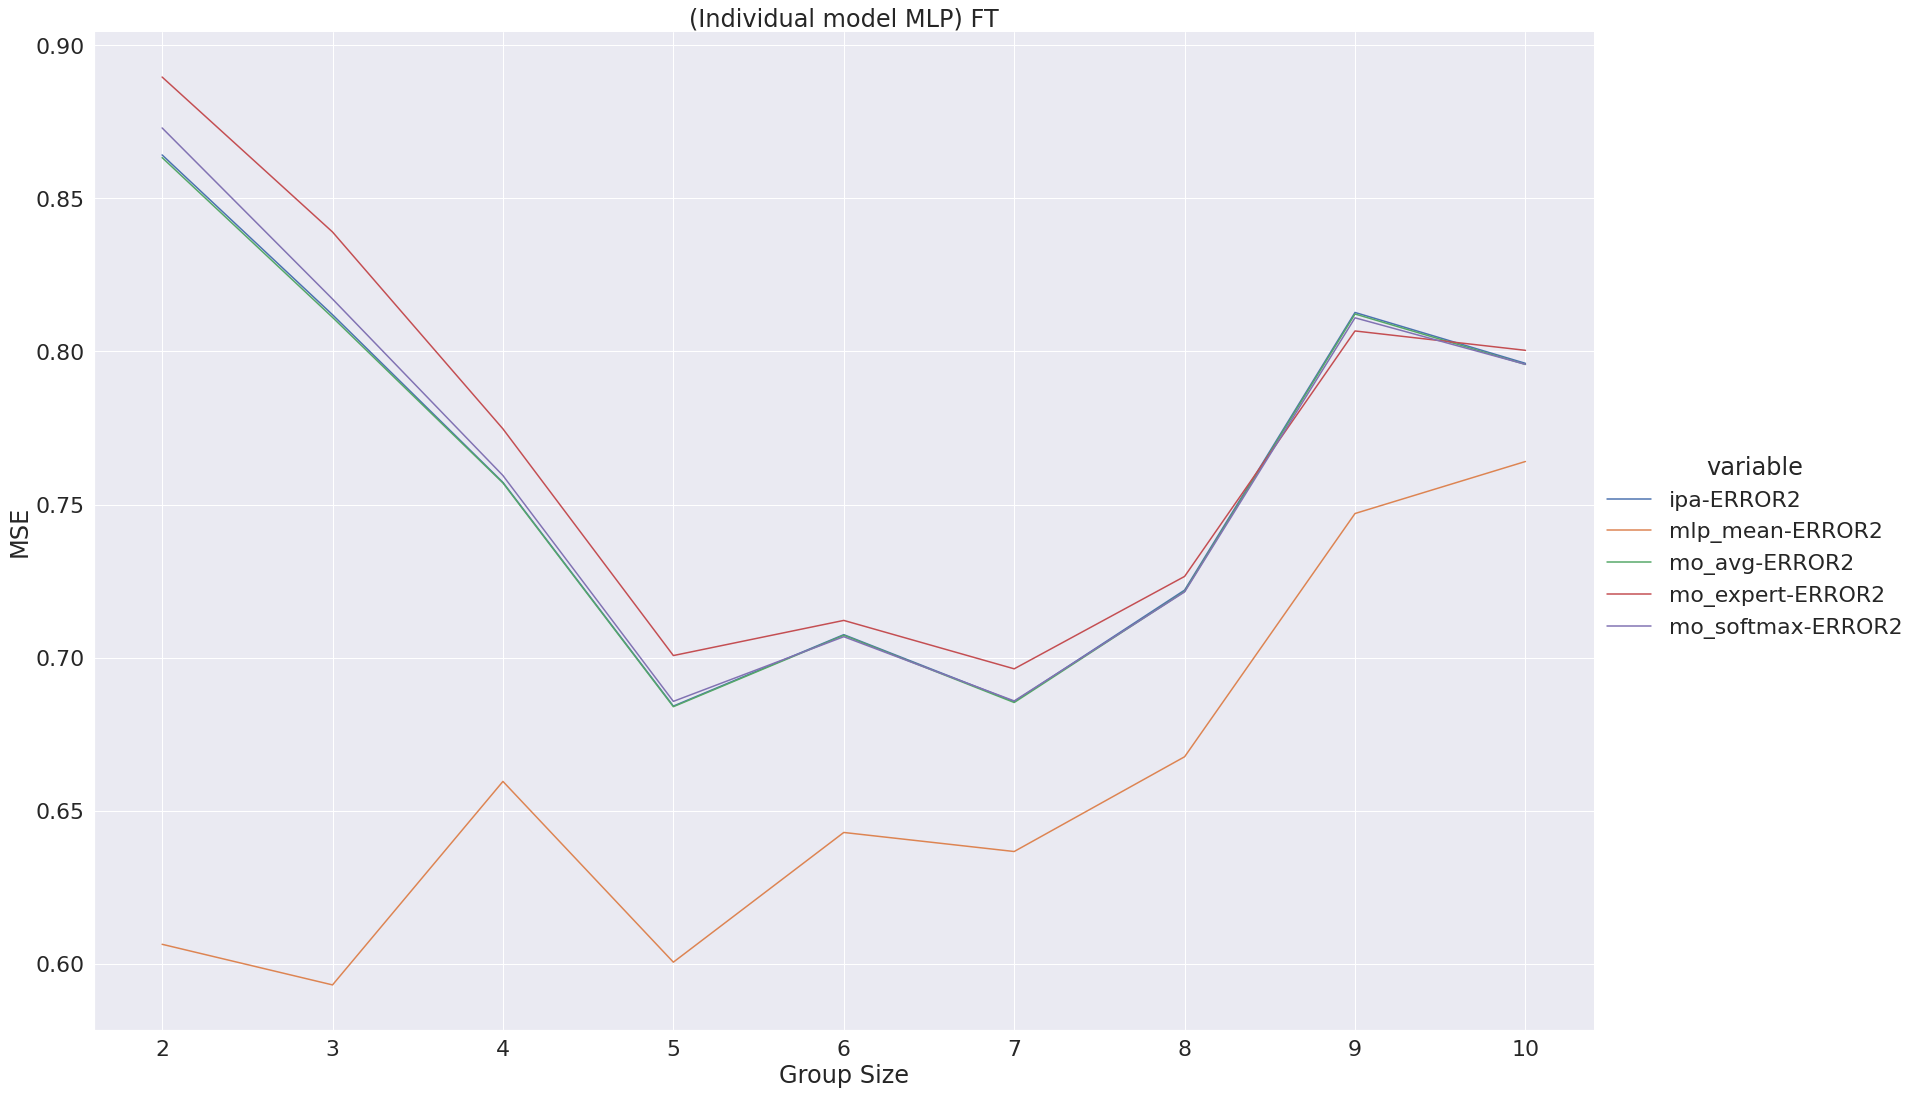

In [8]:
means, results, results_dict = get_error(get_models_files('mlp'), 'ft')
barplot(results, "ERROR", "MAE", "Individual model MLP", "FT")
barplot(results, "ERROR2", "MSE", "Individual model MLP", "FT")
lineplot(results, "ERROR", "MAE", "Individual model MLP", "FT")
lineplot(results, "ERROR2", "MSE", "Individual model MLP", "FT")


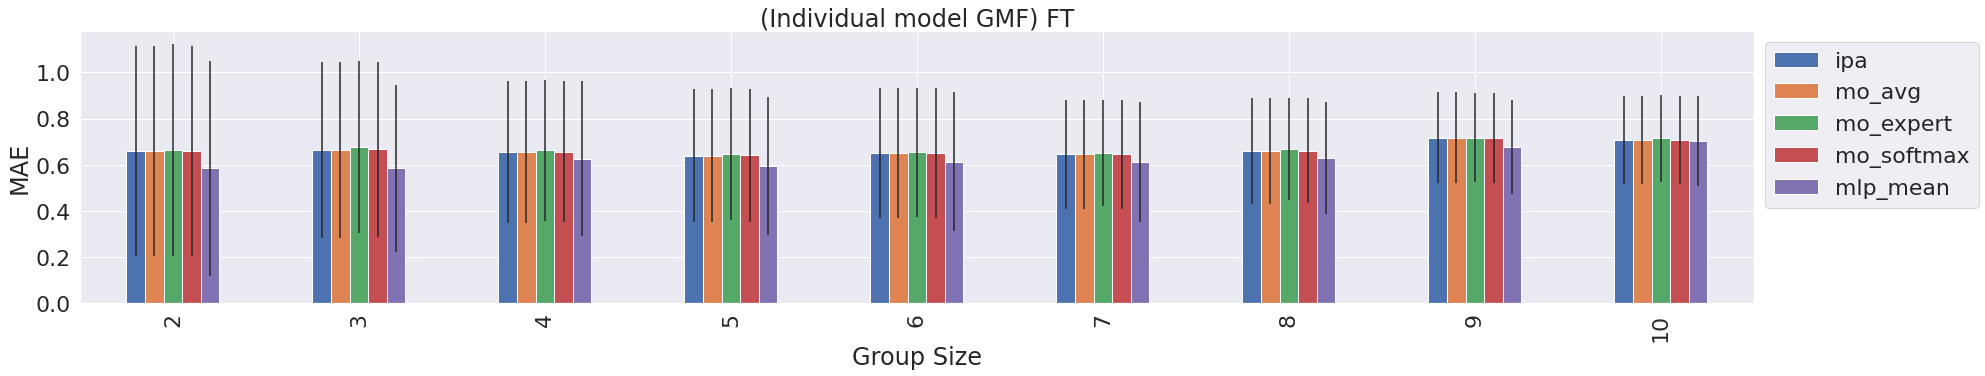

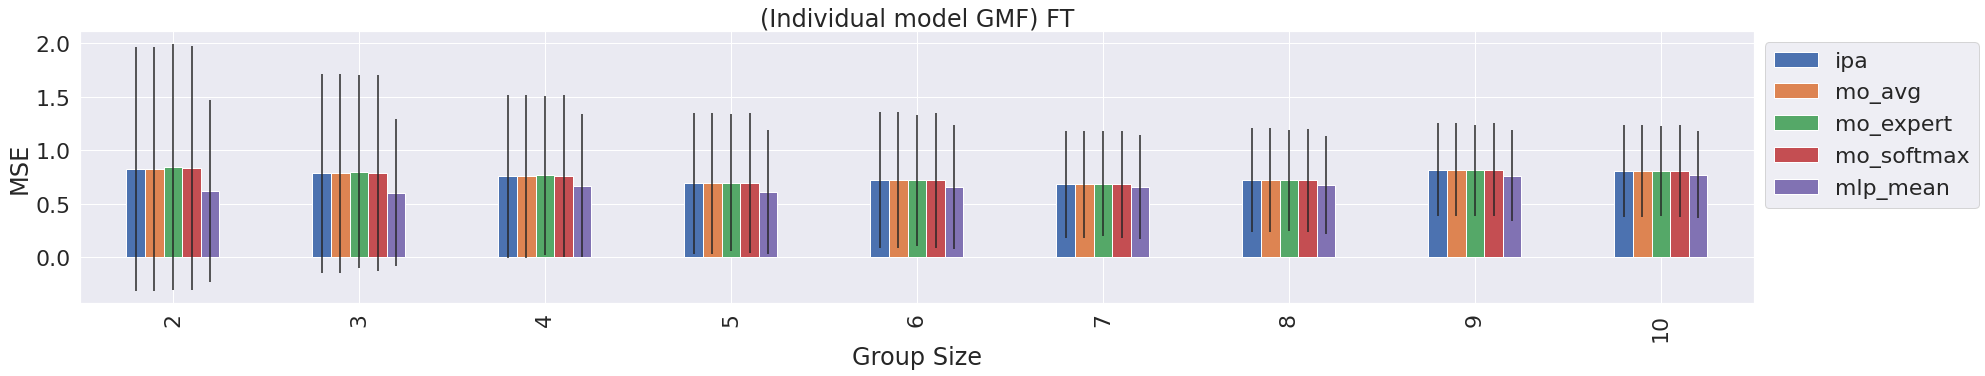

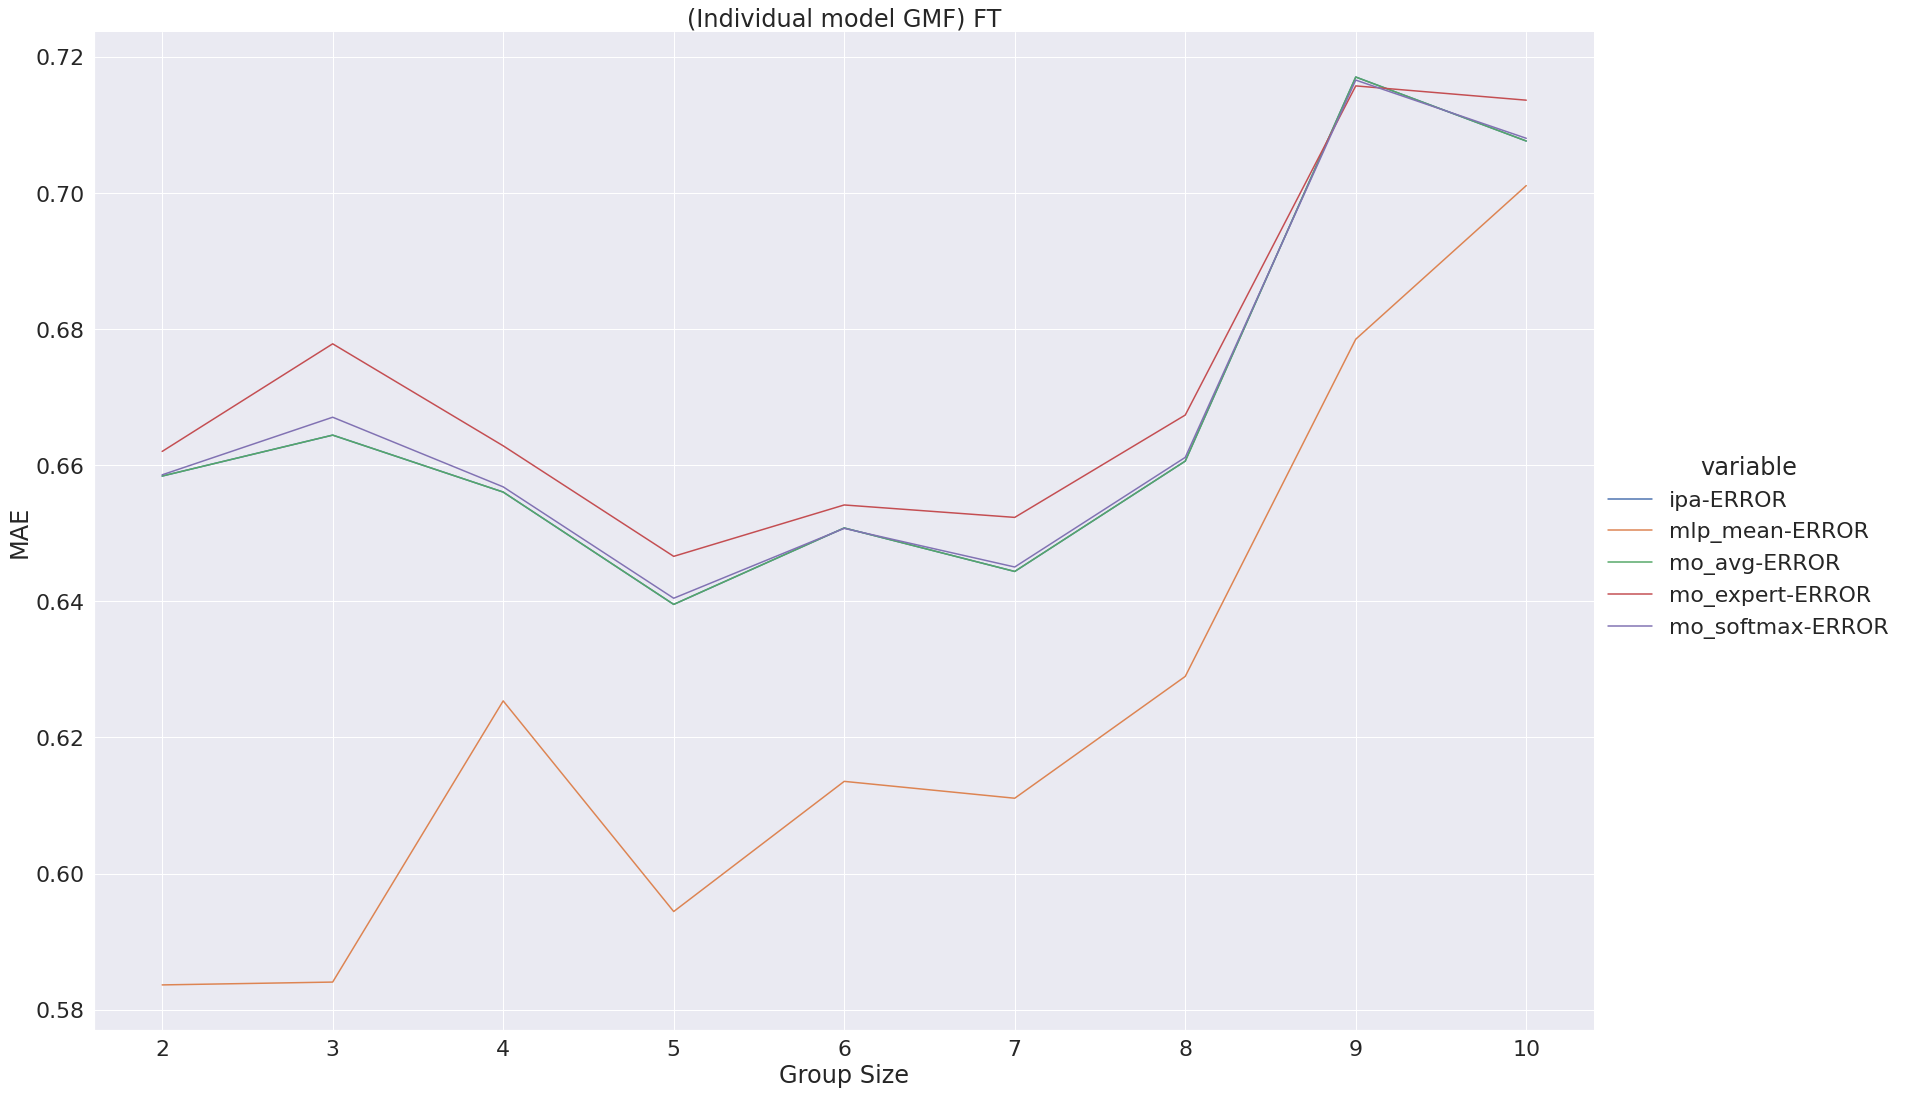

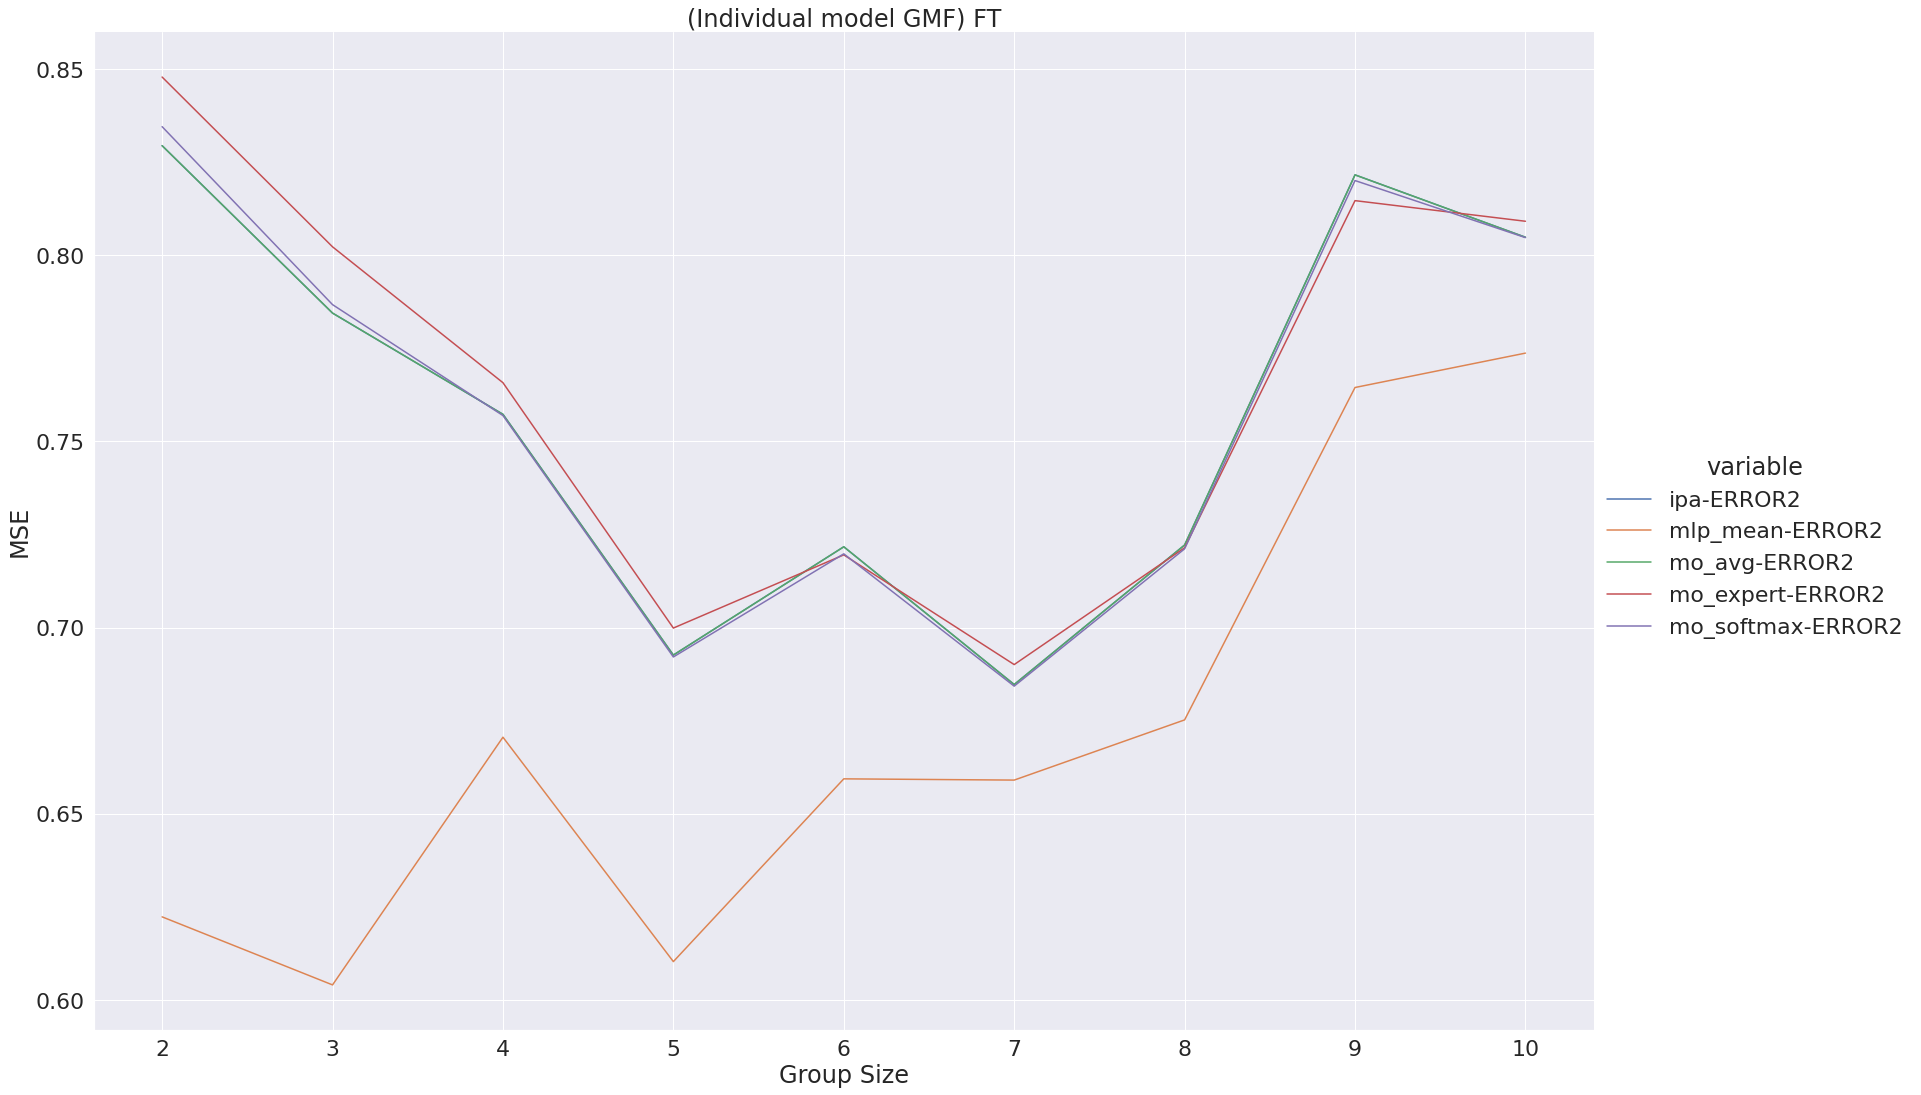

In [9]:
means, results, results_dict = get_error(get_models_files('gmf'), 'ft')
barplot(results, "ERROR", "MAE", "Individual model GMF", "FT")
barplot(results, "ERROR2", "MSE", "Individual model GMF", "FT")
lineplot(results, "ERROR", "MAE", "Individual model GMF", "FT")
lineplot(results, "ERROR2", "MSE", "Individual model GMF", "FT")

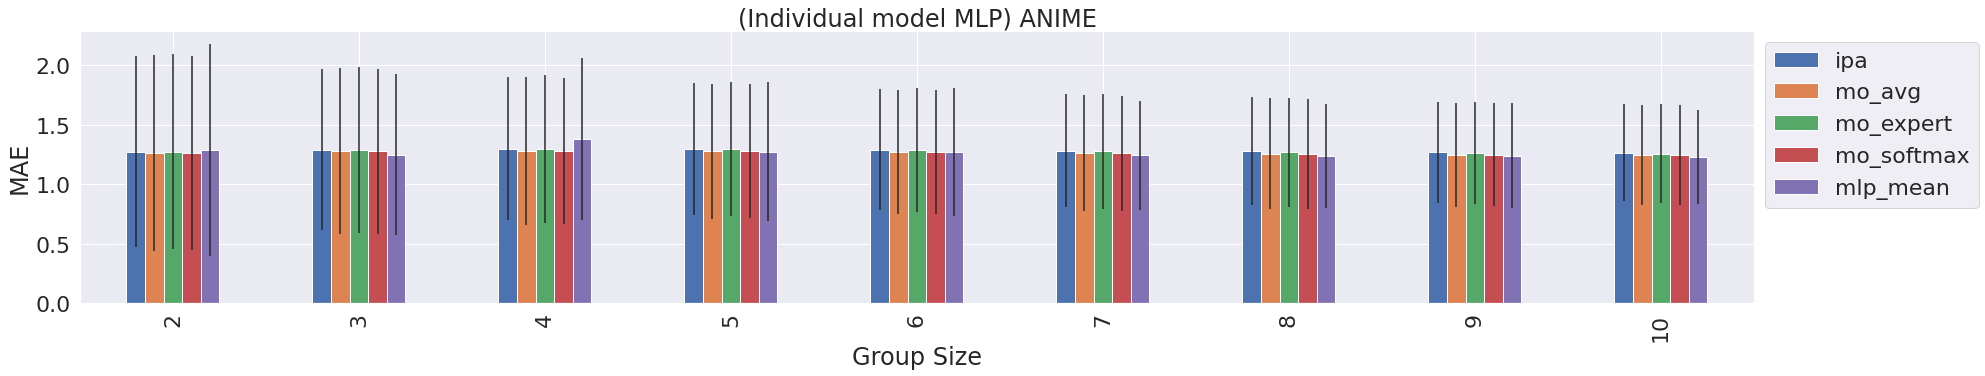

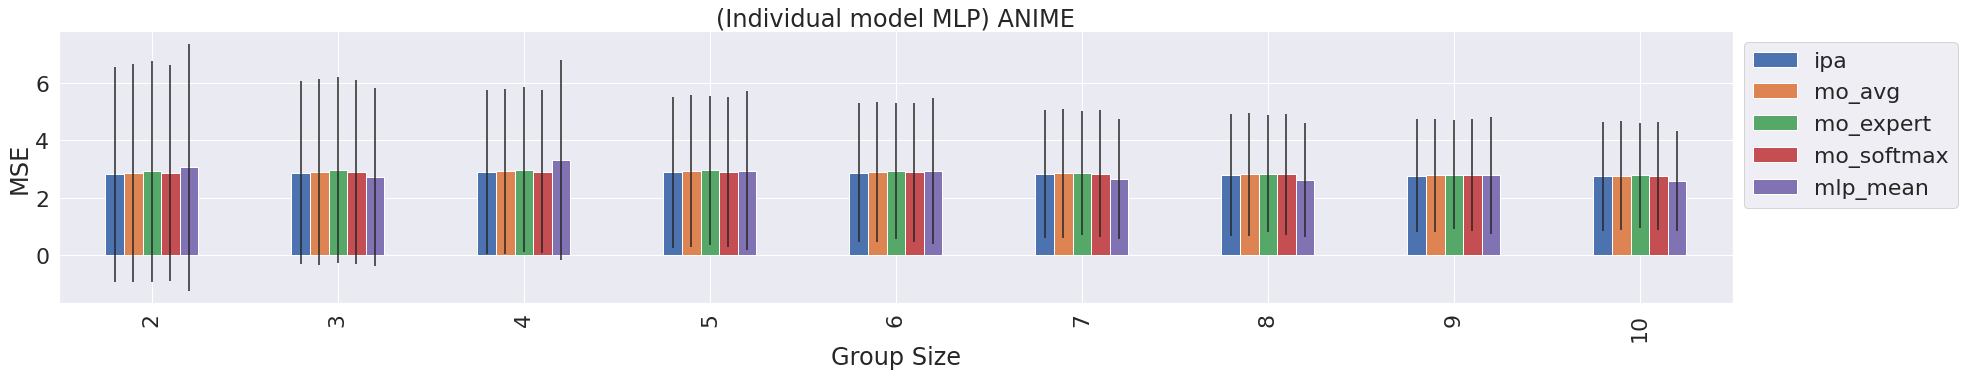

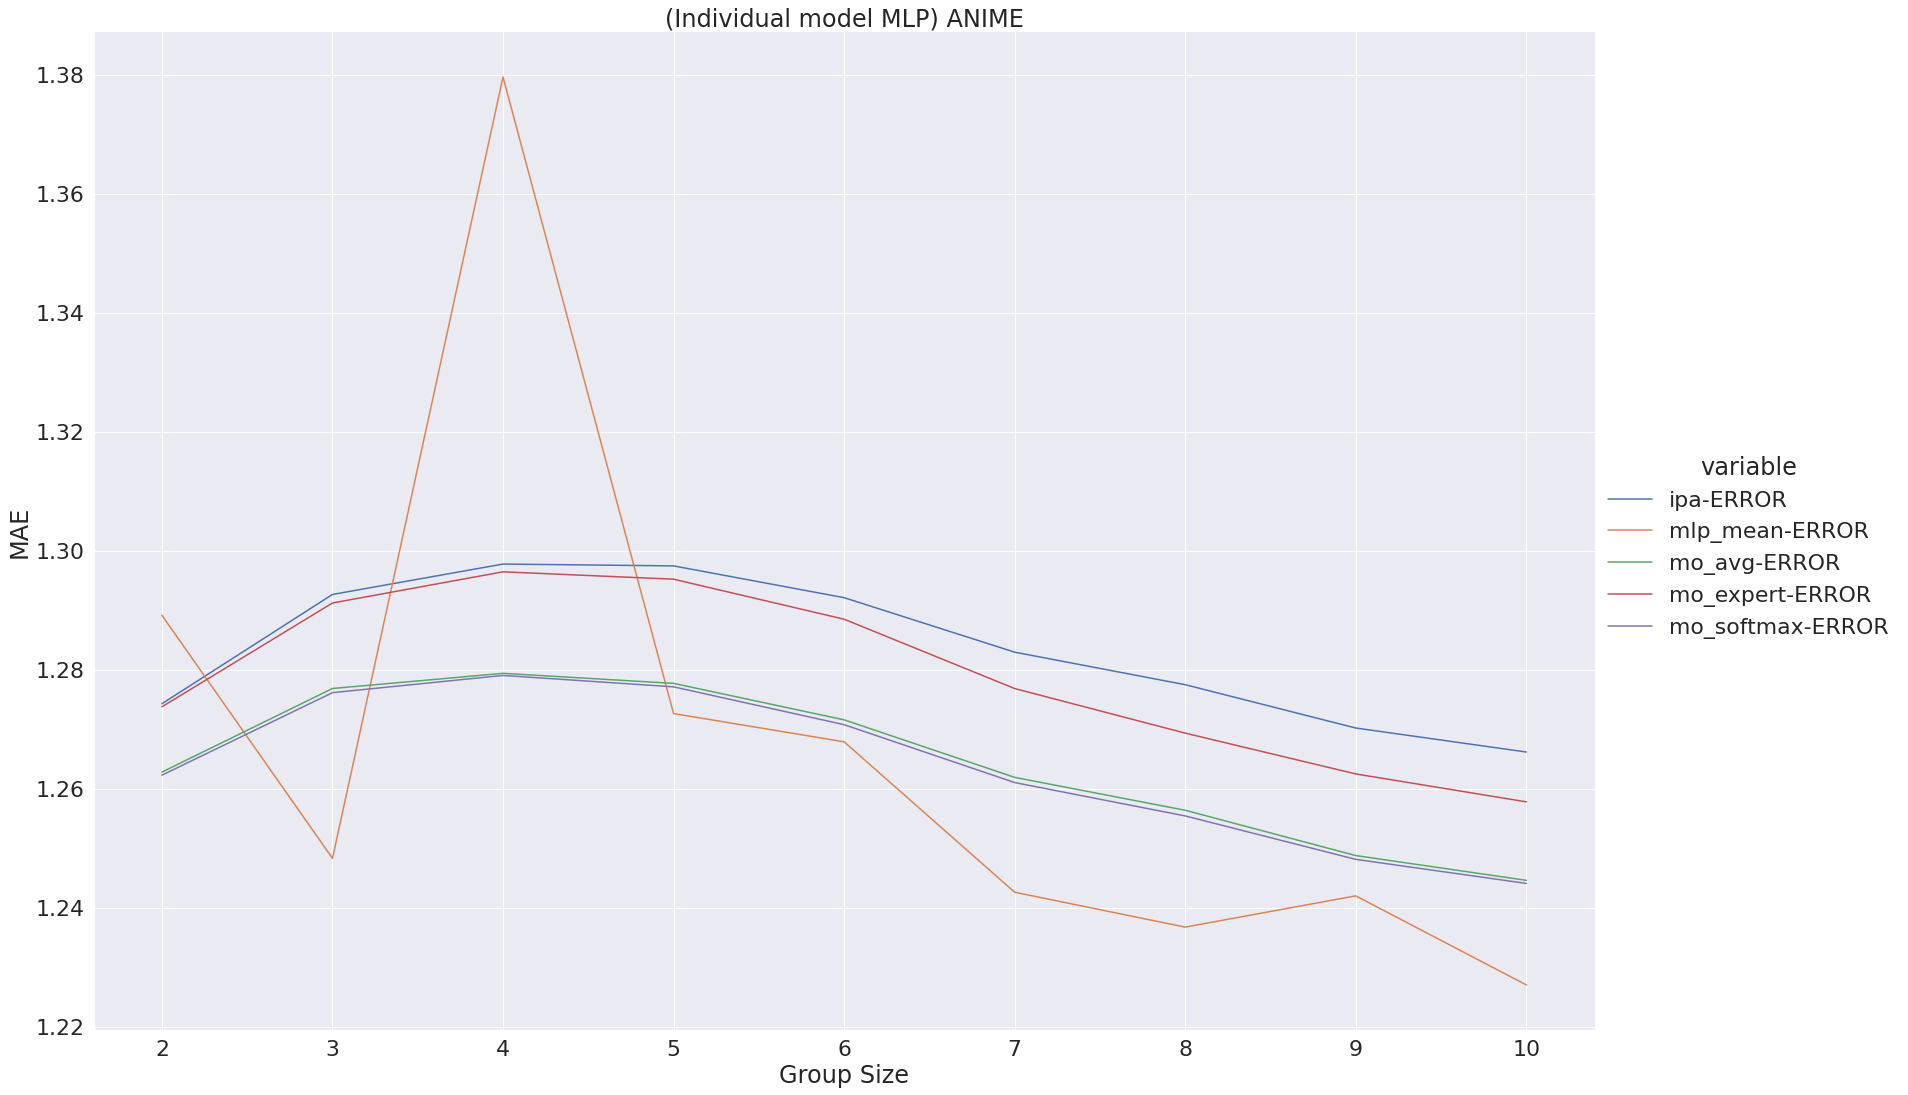

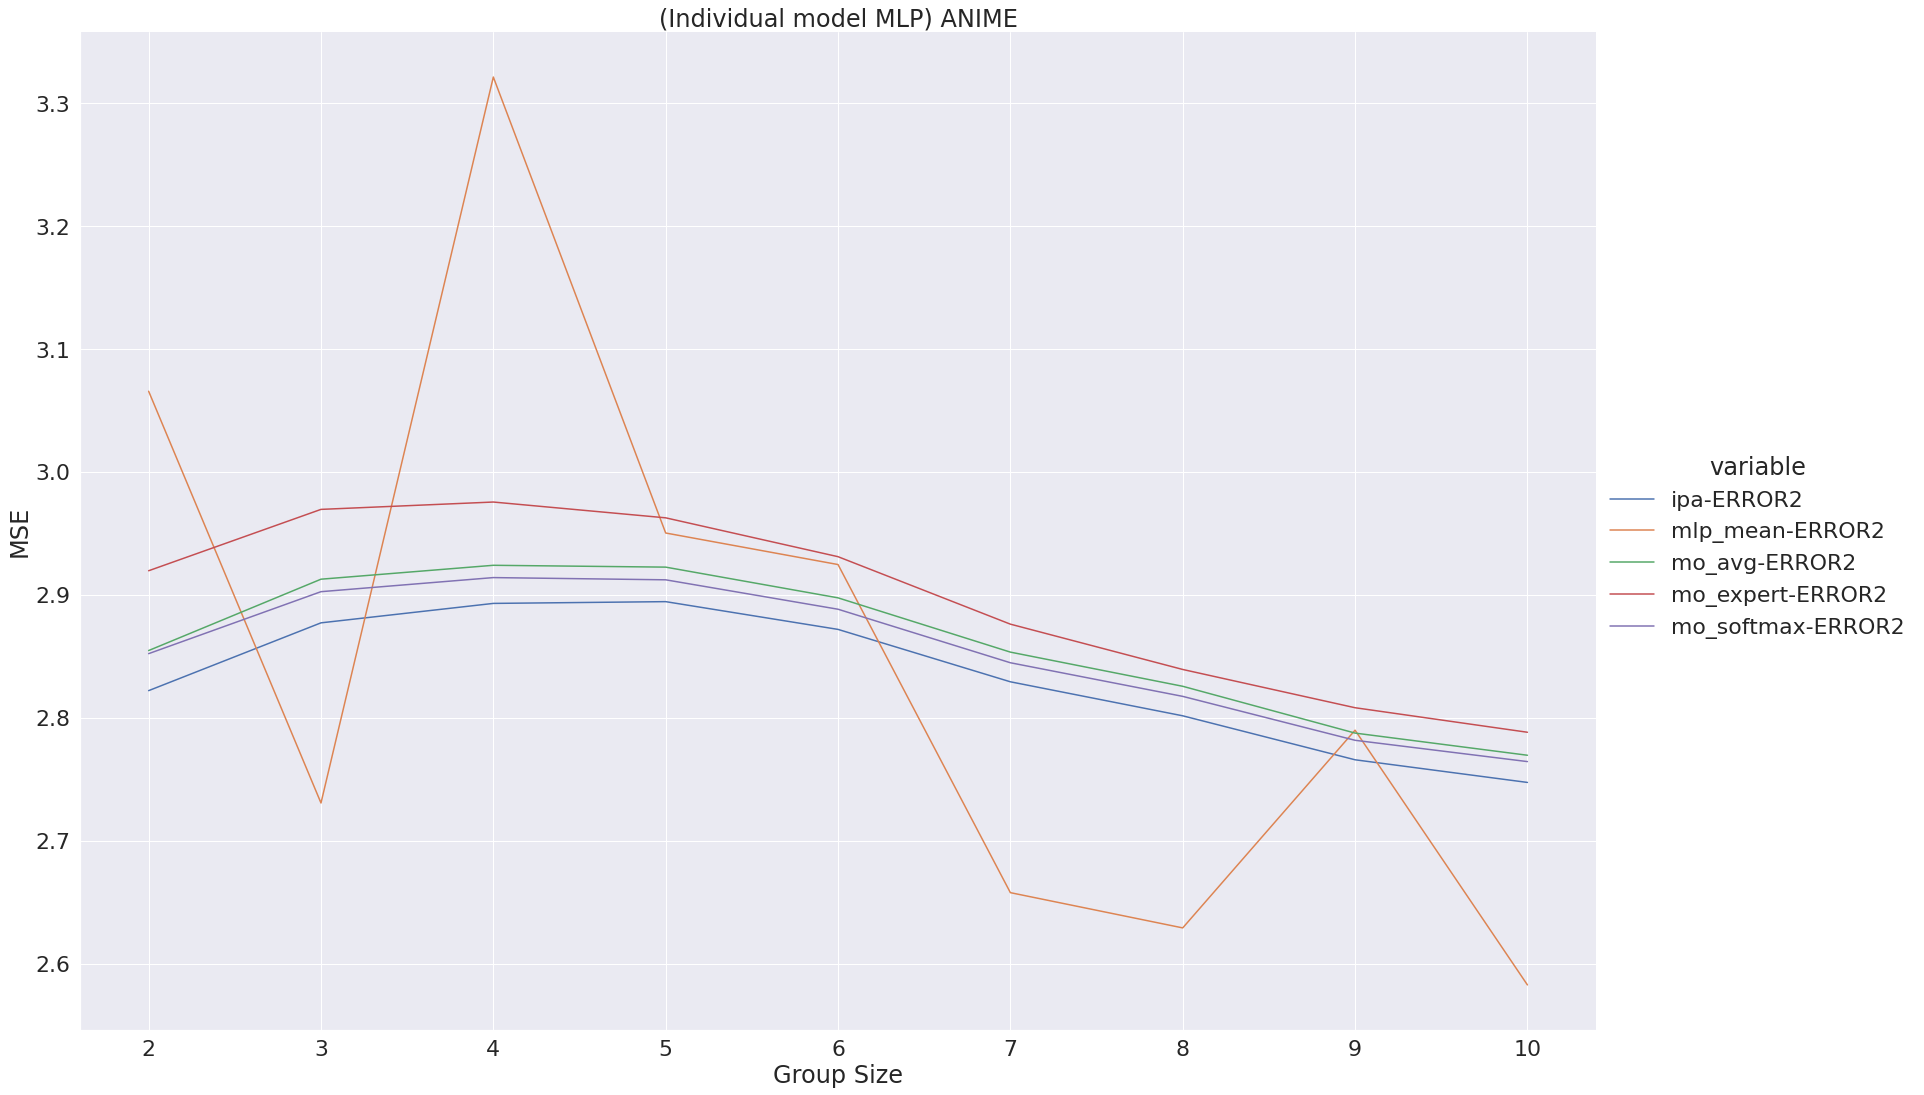

In [10]:
means, results, results_dict = get_error(get_models_files('mlp'), 'anime')
barplot(results, "ERROR", "MAE", "Individual model MLP", "ANIME")
barplot(results, "ERROR2", "MSE", "Individual model MLP", "ANIME")
lineplot(results, "ERROR", "MAE", "Individual model MLP", "ANIME")
lineplot(results, "ERROR2", "MSE", "Individual model MLP", "ANIME")

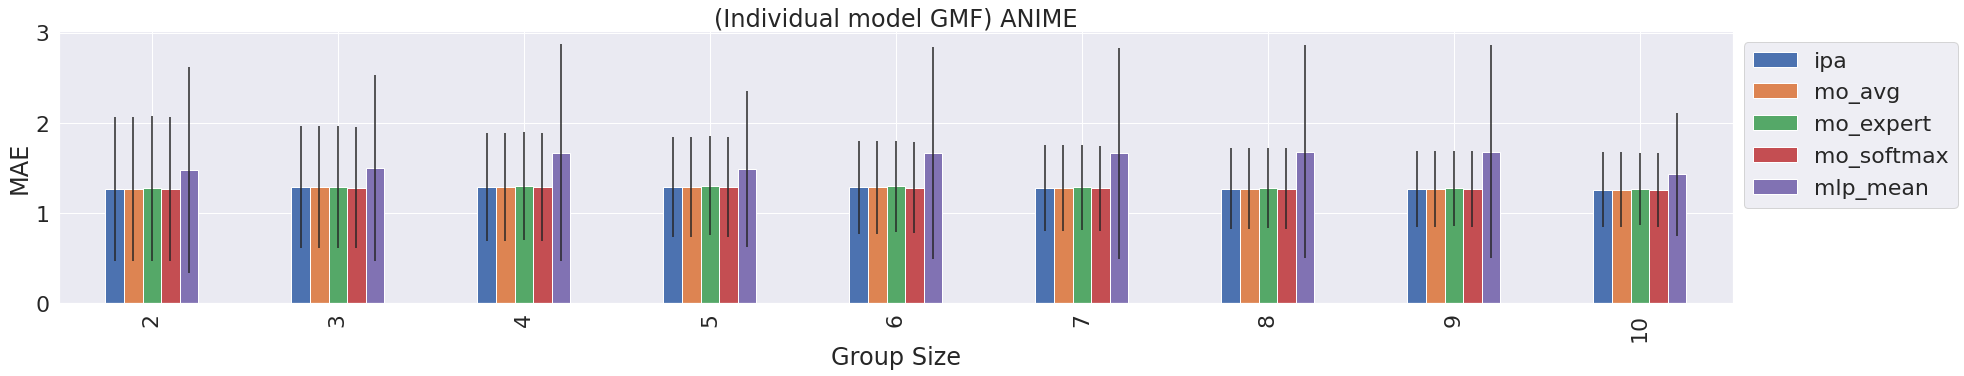

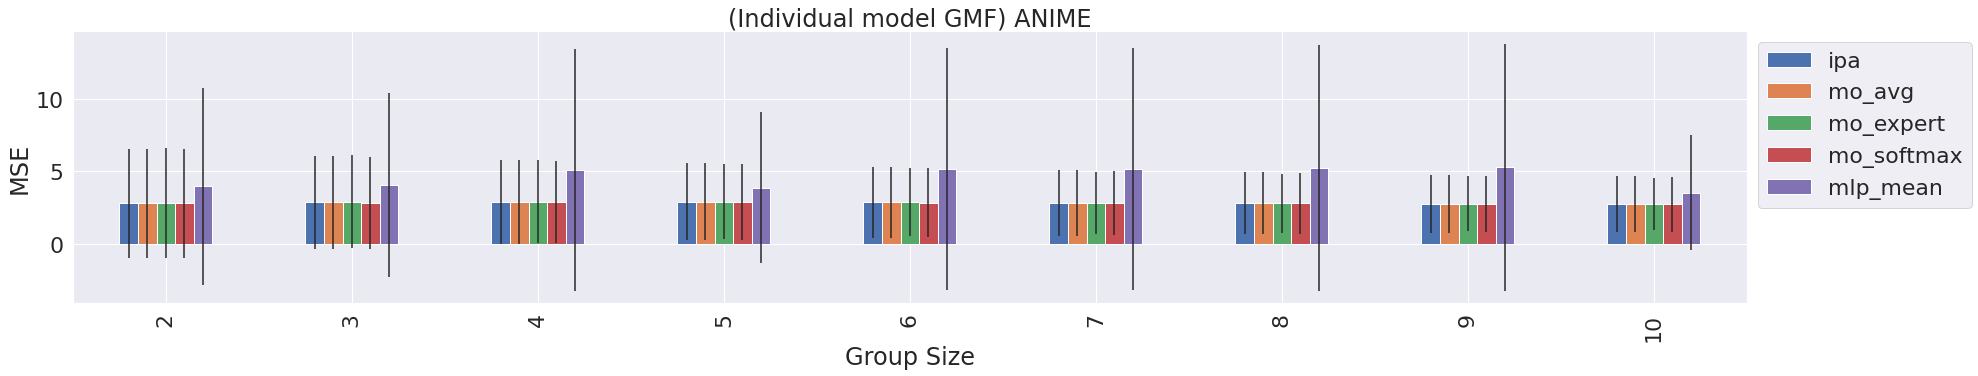

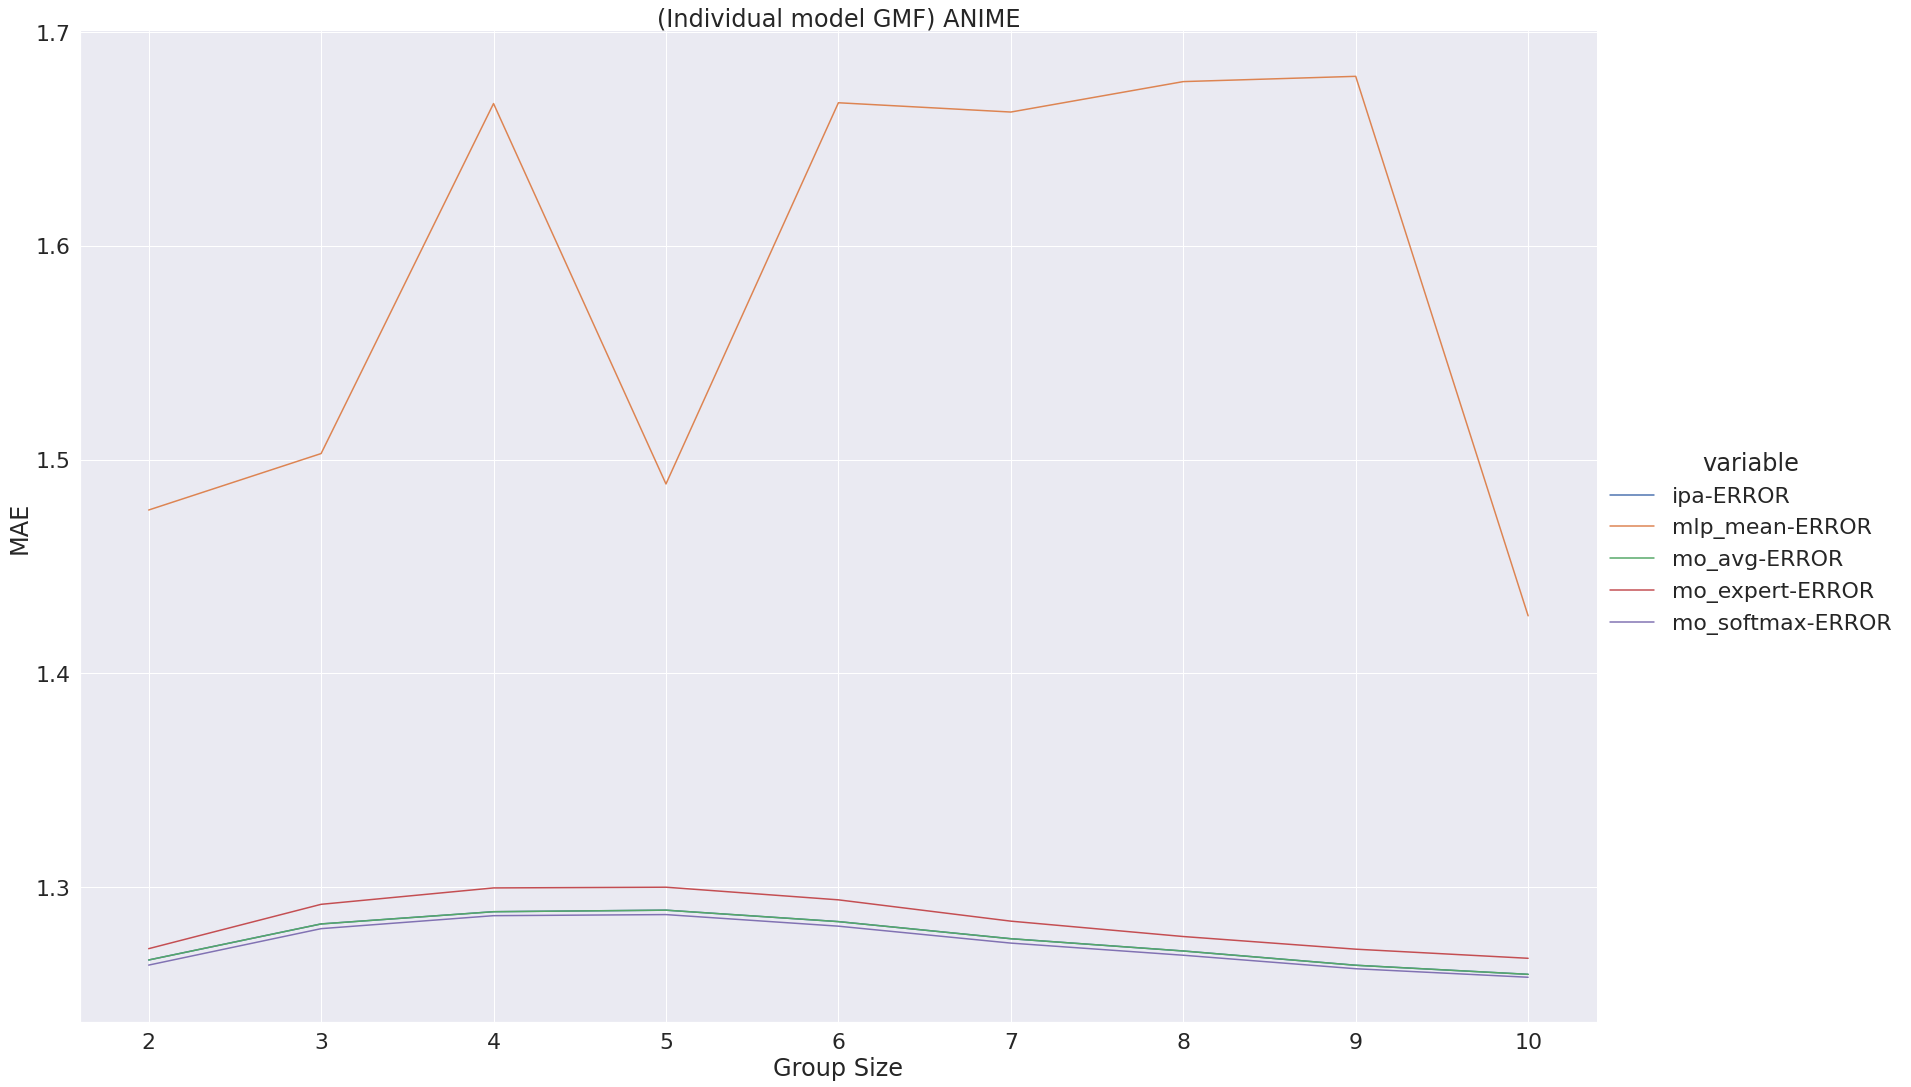

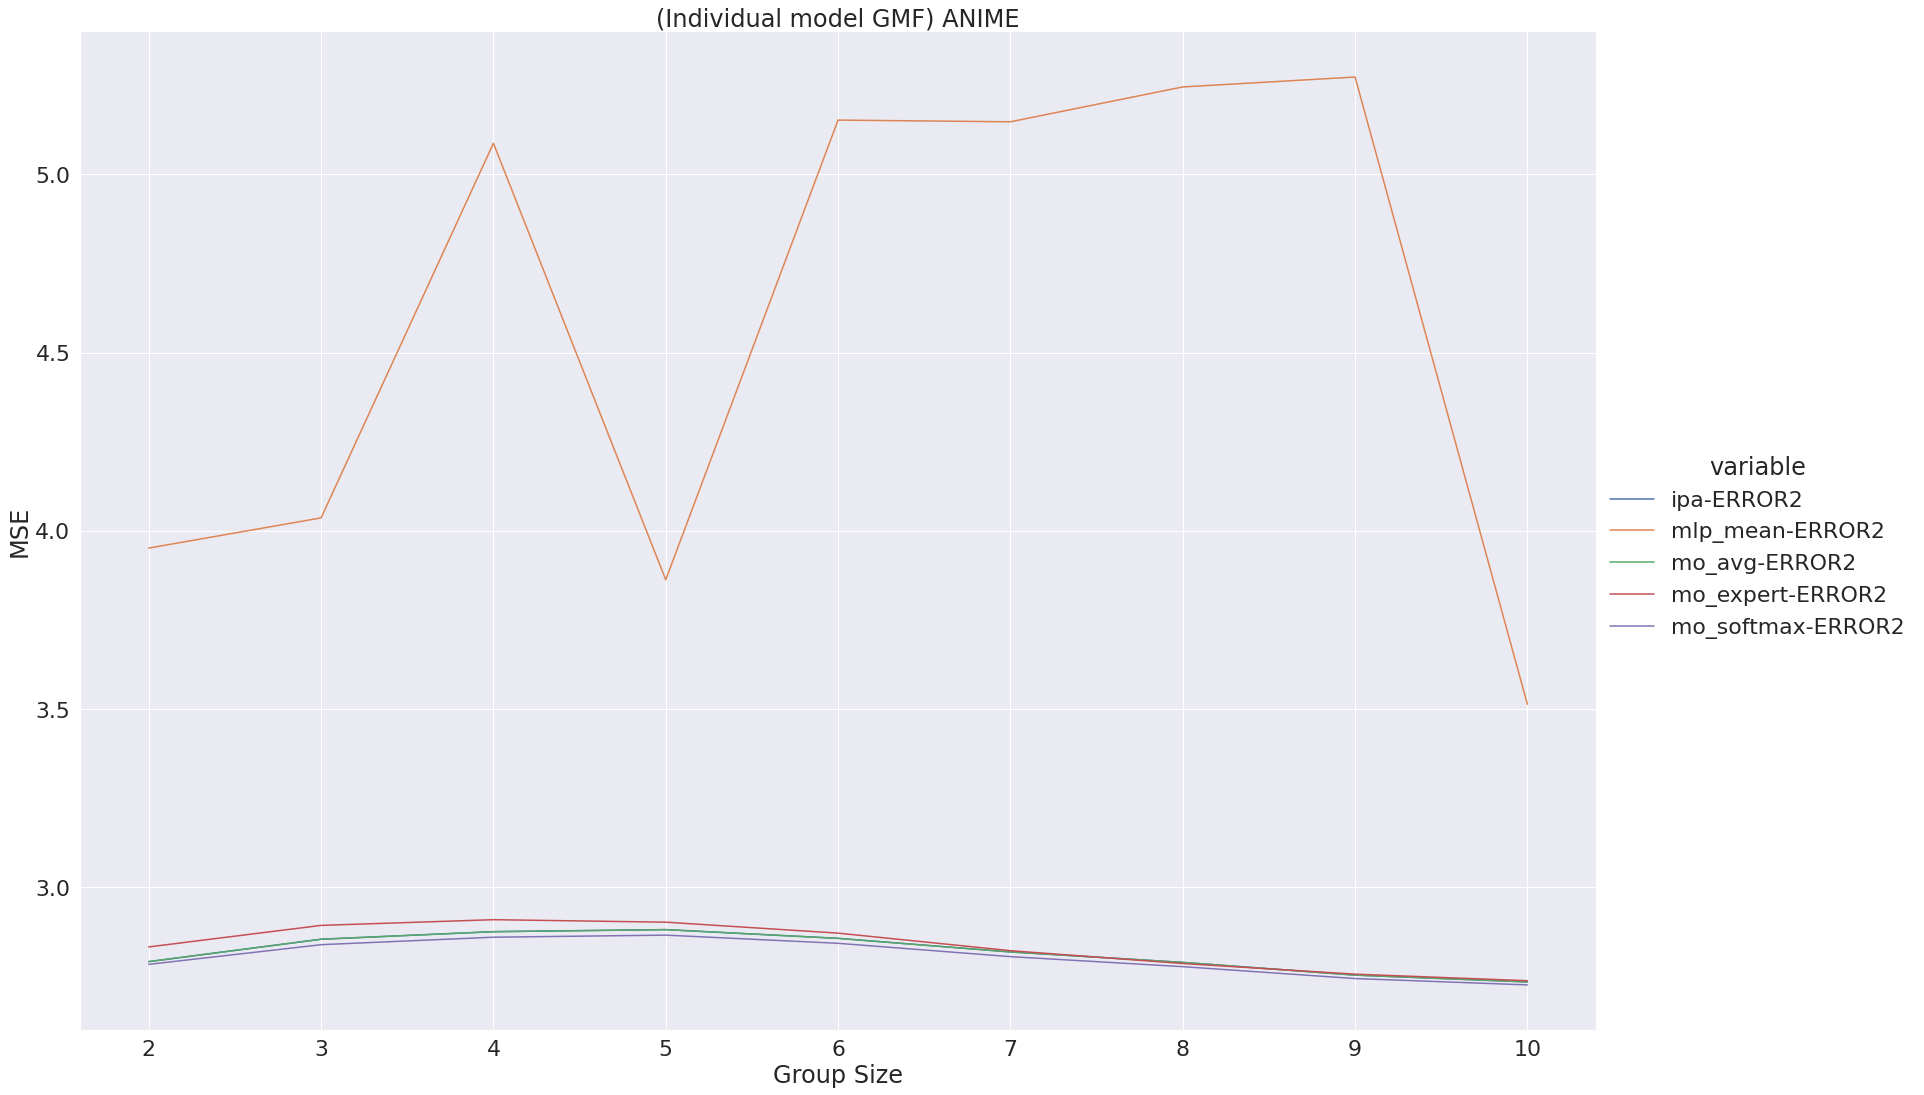

In [11]:
means, results, results_dict = get_error(get_models_files('gmf'), 'anime')
barplot(results, "ERROR", "MAE", "Individual model GMF", "ANIME")
barplot(results, "ERROR2", "MSE", "Individual model GMF", "ANIME")
lineplot(results, "ERROR", "MAE", "Individual model GMF", "ANIME")
lineplot(results, "ERROR2", "MSE", "Individual model GMF", "ANIME")

In [ ]:
means, results, results_dict = get_error(get_models_files('mlp'), 'anime')
barplot(results, "ERROR", "MAE", "Individual model MLP", "ANIME")
barplot(results, "ERROR2", "MSE", "Individual model MLP", "ANIME")

means, results, results_dict = get_error(get_models_files('gmf'), 'anime')
barplot(results, "ERROR", "MAE", "Individual model GMF", "ANIME")
barplot(results, "ERROR2", "MSE", "Individual model GMF", "ANIME")

In [ ]:
models = [m+'-ERROR' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MAE ML1M')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MAE')
plt.show()

In [ ]:
models = [m+'-ERROR2' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MSE ML1M')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MSE')
plt.show()

In [ ]:
means, results, results_dict = get_error(get_models_files('mlp'), 'ft')

In [ ]:
models = [m+'-ERROR' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MAE FT')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MAE')
plt.show()

In [ ]:
models = [m+'-ERROR2' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MSE FT')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MSE')
plt.show()

In [ ]:
means, results, results_dict = get_error(get_models_files('mlp'), 'anime')

In [ ]:
models = [m+'-ERROR' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MAE ANIME')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MAE')
plt.show()

In [ ]:
models = [m+'-ERROR2' for m in get_models_files('mlp').keys()]
long_data = pd.melt(results[['g']+models], id_vars =['g'], value_vars=models)
ax = sns.relplot(
    data=long_data.groupby(['g','variable']).mean(), kind="line",
    x="g", y="value", hue="variable",
    height=15, aspect=1.5
)
ax.set(title='MSE ANIME')
ax.axes[0,0].set_xlabel('Group Size')
ax.axes[0,0].set_ylabel('MSE')
plt.show()